# Dataset

**Reading the dataset that is provided**

In [1]:
my_file = open("C:\\database.txt", "r")
data = my_file.read()

**Dividing the time series samples into different classes based on their first element of the data points**

In [2]:
from collections import defaultdict
sample_list = []
pointClassPairs = defaultdict(list)

samples = data.split("\n")
for sample in samples:
    sample_list.append(sample)

for idx in sample_list:
    dataPoints = idx.split(" ")
    cleaned_string = dataPoints[-1].strip()
    try:
        classValue = int(float(cleaned_string))
        dataPoints_list = dataPoints[:-1]
        dataPoints_val = [round(float(item), 4) for item in dataPoints_list]
        pointClassPairs[classValue].append(dataPoints_val)

    except ValueError:
        print("")

for i in pointClassPairs.keys():
    print(f"Class {i} has {len(pointClassPairs[i])} samples")

dataframe_list = []


Class 1 has 95 samples
Class 2 has 73 samples
Class 3 has 96 samples
Class 4 has 89 samples
Class 5 has 24 samples


**Defining the time series that is used for synthesizing and displaying two random time series samples from class 3 for the demonstration (to be used in paper)**

In [3]:
pip install arviz

Note: you may need to restart the kernel to use updated packages.


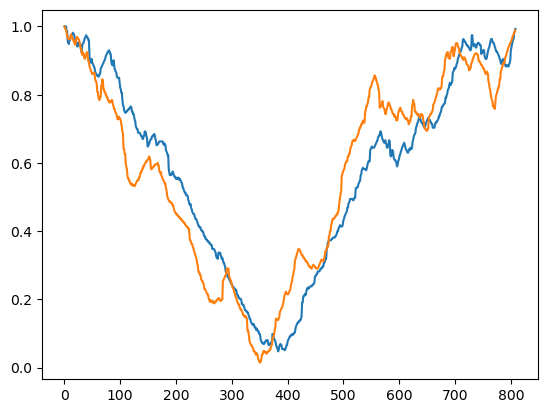

In [4]:
import arviz as az
import numpy
import matplotlib.pyplot as plt
arr = numpy.array(pointClassPairs[1][29])
arr2 = numpy.array(pointClassPairs[1][69])

test1 = numpy.array(pointClassPairs[3][3])
test2 = numpy.array(pointClassPairs[3][55])


plt.plot(test1)
plt.plot(test2)
plt.show()

**Plotting the Kernel Density Estimates**

<Axes: >

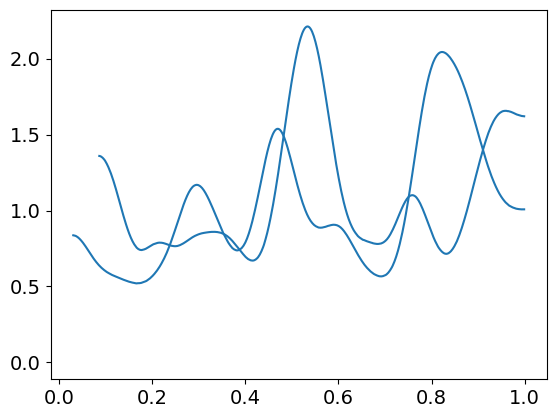

In [5]:
az.plot_kde(arr)
az.plot_kde(arr2)

**Finding the time series samples that has the same amount of data points. This is vital since our method requires two time series samples with exact same length in order to synthesized (or they should be normalized into same lenght)**

In [6]:
len_list = []

for index, val in enumerate(pointClassPairs[3]):
    len_list.append(len(pointClassPairs[3][index]))


In [7]:
from collections import Counter
from collections import defaultdict

# Create a dictionary to store indices of each element
index_dict = {}
for i, item in enumerate(len_list):
    if item in index_dict:
        index_dict[item].append(i)
    else:
        index_dict[item] = [i]

# Filter out elements with only one occurrence
repeating_elements = {k: v for k, v in index_dict.items() if len(v) > 1}

print(repeating_elements)

{815: [2, 44], 809: [3, 55], 1053: [13, 28], 859: [23, 91], 824: [26, 37], 947: [61, 74], 960: [65, 70]}


**Plotting five different time series samples from each class**

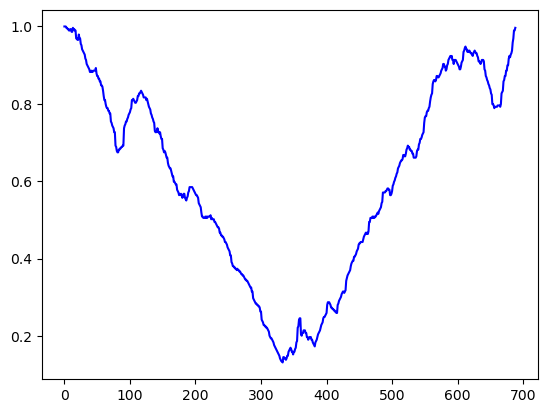

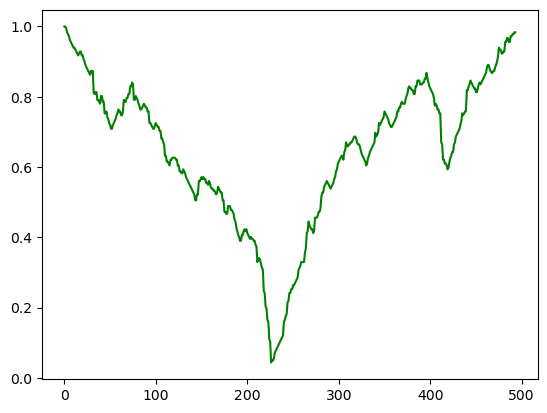

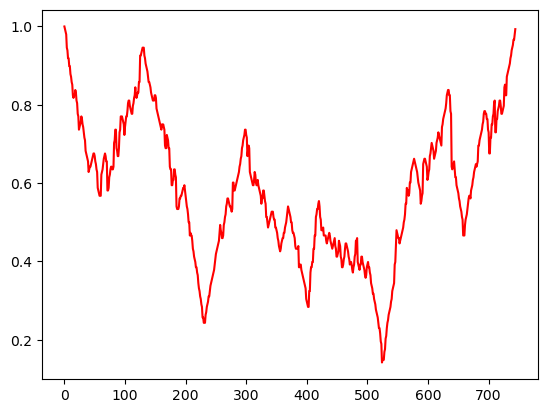

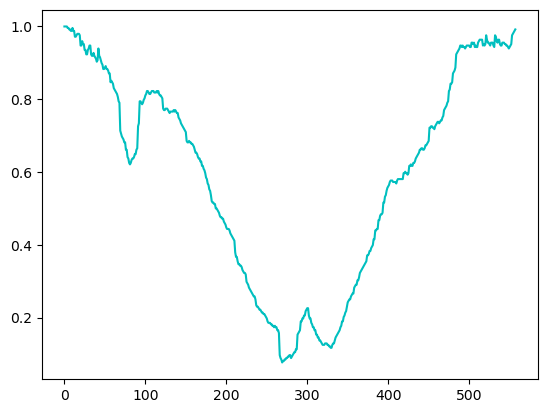

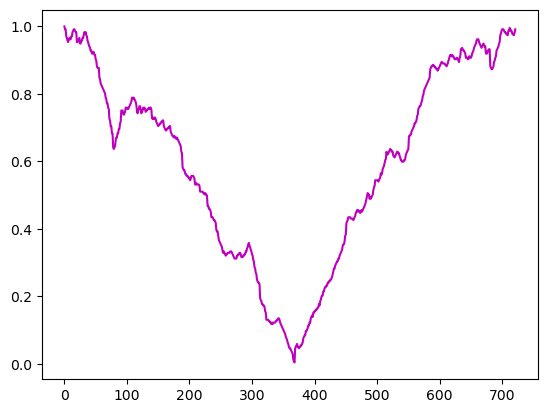

In [8]:
import random
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

for i in range(5):
    plt.plot(pointClassPairs[i+1][random.randrange(1,24,1)], color=colors[i])
    plt.show()


**Visualizing the correlation between two time series samples that we are using for synthesizing**

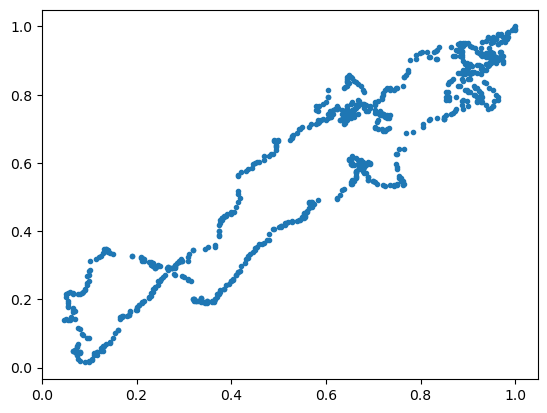

In [9]:
plt.plot(test1, test2, 'C0. ')
plt.show()

# Synthesizing time series

**Defining the Bayesian model with Gaussian distrubition with priors and finding the trace for posterior predicitive sampling**

## Preprocessing
**Original time series are normalized to a lenght in order to feed all the samples for data generation**

In [10]:
import numpy as np

def resample_time_series(data, target_length):
    """
    Resample each time series to have the same target length using interpolation.
    """
    resampled = []
    for ts in data:
        x_old = np.linspace(0, 1, len(ts))
        x_new = np.linspace(0, 1, target_length)
        resampled.append(np.interp(x_new, x_old, ts))
    return np.array(resampled)

# Determine the target length (e.g., shortest length or a specific fixed length)
target_length = min(len(ts) for ts in pointClassPairs[1])  # Use the shortest time series length
normalized_samples = resample_time_series(pointClassPairs[1], target_length)

**Normalizing class 2 (in length of class 1)**

In [11]:
target_length = min(len(ts) for ts in pointClassPairs[1])
normalized_samples_secondClass = resample_time_series(pointClassPairs[2], target_length)
normalized_samples_thirdClass = resample_time_series(pointClassPairs[3], target_length)
normalized_samples_fourthClass = resample_time_series(pointClassPairs[4], target_length)
normalized_samples_fifthClass = resample_time_series(pointClassPairs[5], target_length)

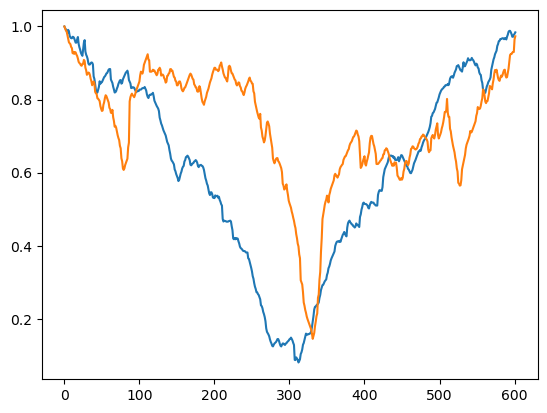

In [12]:
plt.plot(normalized_samples[34])
plt.plot(normalized_samples_secondClass[34])
plt.show()

In [13]:
# Generate the input (time indices) and output (observed values)
arr_input = np.tile(np.arange(target_length), (len(normalized_samples), 1))  # Time indices
arr_output = normalized_samples  # Observed time series values

## Modeling

**Synthesizing for the class 1**

In [14]:
pip install pymc

In [16]:

import pymc as pm
import numpy as np

n_samples, n_timepoints = arr_output.shape

with pm.Model() as time_series_model:
    # Shared latent factor (captures common patterns across series)
    shared_trend = pm.Normal('shared_trend', mu=0, sigma=1, shape=n_timepoints)

    # Per-series scaling and offset
    a = pm.Normal('a', mu=0, sigma=1, shape=n_samples)  # Intercepts for each series
    b = pm.Normal('b', mu=1, sigma=0.5, shape=n_samples)  # Slopes for each series

    # Unique random walk for each time series (adds uniqueness)
    unique_trend = pm.GaussianRandomWalk('unique_trend', sigma=0.1, shape=(n_samples, n_timepoints))

    # Combine shared and unique patterns
    u = pm.Deterministic(
        'u',
        a[:, None] + b[:, None] * shared_trend + unique_trend
    )

    # Likelihood for the observed time series
    yPred = pm.Normal('yPred', mu=u, sigma=0.05, observed=arr_output)

    # Sampling the posterior
    trace = pm.sample(1, tune=500, chains=1, cores=1)

# Generate synthetic time series from the posterior predictive distribution
with time_series_model:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=['u'])


C:\Users\mrnew\anaconda3\Lib\site-packages\pymc\distributions\timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Only 1 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [shared_trend, a, b, unique_trend]


Output()

Sampling 1 chain for 500 tune and 1 draw iterations (500 + 1 draws total) took 356 seconds.
The number of samples is too small to check convergence reliably.
Sampling: []


Output()

**Synthesizing for the class 2**

In [17]:
# Generate the input (time indices) and output (observed values)
arr_input_class2 = np.tile(np.arange(target_length), (len(normalized_samples_secondClass), 1))  # Time indices
arr_output_class2 = normalized_samples_secondClass  # Observed time series values

In [18]:

import pymc as pm
import numpy as np

n_samples, n_timepoints = arr_output_class2.shape

with pm.Model() as time_series_model:
    # Shared latent factor (captures common patterns across series)
    shared_trend = pm.Normal('shared_trend', mu=0, sigma=1, shape=n_timepoints)

    # Per-series scaling and offset
    a = pm.Normal('a', mu=0, sigma=1, shape=n_samples)  # Intercepts for each series
    b = pm.Normal('b', mu=1, sigma=0.5, shape=n_samples)  # Slopes for each series

    # Unique random walk for each time series (adds uniqueness)
    unique_trend = pm.GaussianRandomWalk('unique_trend', sigma=0.1, shape=(n_samples, n_timepoints))

    # Combine shared and unique patterns
    u = pm.Deterministic(
        'u',
        a[:, None] + b[:, None] * shared_trend + unique_trend
    )

    # Likelihood for the observed time series
    yPred_second = pm.Normal('yPred', mu=u, sigma=0.05, observed=arr_output_class2)

    # Sampling the posterior
    trace = pm.sample(1, tune=500, chains=1, cores=1)

# Generate synthetic time series from the posterior predictive distribution
with time_series_model:
    posterior_predictive_second = pm.sample_posterior_predictive(trace, var_names=['u'])


C:\Users\mrnew\anaconda3\Lib\site-packages\pymc\distributions\timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Only 1 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [shared_trend, a, b, unique_trend]


Output()

Sampling 1 chain for 500 tune and 1 draw iterations (500 + 1 draws total) took 258 seconds.
The number of samples is too small to check convergence reliably.
Sampling: []


Output()

Synthesizing for the class 3

In [19]:
# Generate the input (time indices) and output (observed values)
arr_input_class3 = np.tile(np.arange(target_length), (len(normalized_samples_thirdClass), 1))  # Time indices
arr_output_class3 = normalized_samples_thirdClass  # Observed time series values

In [20]:
n_samples, n_timepoints = arr_output_class3.shape

with pm.Model() as time_series_model:
    # Shared latent factor (captures common patterns across series)
    shared_trend = pm.Normal('shared_trend', mu=0, sigma=1, shape=n_timepoints)

    # Per-series scaling and offset
    a = pm.Normal('a', mu=0, sigma=1, shape=n_samples)  # Intercepts for each series
    b = pm.Normal('b', mu=1, sigma=0.5, shape=n_samples)  # Slopes for each series

    # Unique random walk for each time series (adds uniqueness)
    unique_trend = pm.GaussianRandomWalk('unique_trend', sigma=0.1, shape=(n_samples, n_timepoints))

    # Combine shared and unique patterns
    u = pm.Deterministic(
        'u',
        a[:, None] + b[:, None] * shared_trend + unique_trend
    )

    # Likelihood for the observed time series
    yPred_third = pm.Normal('yPred', mu=u, sigma=0.05, observed=arr_output_class3)

    # Sampling the posterior
    trace = pm.sample(1, tune=500, chains=1, cores=1)

# Generate synthetic time series from the posterior predictive distribution
with time_series_model:
    posterior_predictive_third = pm.sample_posterior_predictive(trace, var_names=['u'])

C:\Users\mrnew\anaconda3\Lib\site-packages\pymc\distributions\timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Only 1 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [shared_trend, a, b, unique_trend]


Output()

Sampling 1 chain for 500 tune and 1 draw iterations (500 + 1 draws total) took 350 seconds.
The number of samples is too small to check convergence reliably.
Sampling: []


Output()

Synthesizing for class 4

In [21]:
# Generate the input (time indices) and output (observed values)
arr_input_class4 = np.tile(np.arange(target_length), (len(normalized_samples_fourthClass), 1))  # Time indices
arr_output_class4 = normalized_samples_fourthClass  # Observed time series values

In [22]:
n_samples, n_timepoints = arr_output_class4.shape

with pm.Model() as time_series_model:
    # Shared latent factor (captures common patterns across series)
    shared_trend = pm.Normal('shared_trend', mu=0, sigma=1, shape=n_timepoints)

    # Per-series scaling and offset
    a = pm.Normal('a', mu=0, sigma=1, shape=n_samples)  # Intercepts for each series
    b = pm.Normal('b', mu=1, sigma=0.5, shape=n_samples)  # Slopes for each series

    # Unique random walk for each time series (adds uniqueness)
    unique_trend = pm.GaussianRandomWalk('unique_trend', sigma=0.1, shape=(n_samples, n_timepoints))

    # Combine shared and unique patterns
    u = pm.Deterministic(
        'u',
        a[:, None] + b[:, None] * shared_trend + unique_trend
    )

    # Likelihood for the observed time series
    yPred_fourth = pm.Normal('yPred', mu=u, sigma=0.05, observed=arr_output_class4)

    # Sampling the posterior
    trace = pm.sample(1, tune=500, chains=1, cores=1)

# Generate synthetic time series from the posterior predictive distribution
with time_series_model:
    posterior_predictive_fourth = pm.sample_posterior_predictive(trace, var_names=['u'])
    

C:\Users\mrnew\anaconda3\Lib\site-packages\pymc\distributions\timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Only 1 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [shared_trend, a, b, unique_trend]


Output()

Sampling 1 chain for 500 tune and 1 draw iterations (500 + 1 draws total) took 300 seconds.
The number of samples is too small to check convergence reliably.
Sampling: []


Output()

Synthesizing for Class 5

In [23]:
# Generate the input (time indices) and output (observed values)
arr_input_class5 = np.tile(np.arange(target_length), (len(normalized_samples_fifthClass), 1))  # Time indices
arr_output_class5 = normalized_samples_fifthClass  # Observed time series values

In [24]:
n_samples, n_timepoints = arr_output_class5.shape

with pm.Model() as time_series_model:
    # Shared latent factor (captures common patterns across series)
    shared_trend = pm.Normal('shared_trend', mu=0, sigma=1, shape=n_timepoints)

    # Per-series scaling and offset
    a = pm.Normal('a', mu=0, sigma=1, shape=n_samples)  # Intercepts for each series
    b = pm.Normal('b', mu=1, sigma=0.5, shape=n_samples)  # Slopes for each series

    # Unique random walk for each time series (adds uniqueness)
    unique_trend = pm.GaussianRandomWalk('unique_trend', sigma=0.1, shape=(n_samples, n_timepoints))

    # Combine shared and unique patterns
    u = pm.Deterministic(
        'u',
        a[:, None] + b[:, None] * shared_trend + unique_trend
    )

    # Likelihood for the observed time series
    yPred_fifth = pm.Normal('yPred', mu=u, sigma=0.05, observed=arr_output_class5)

    # Sampling the posterior
    trace = pm.sample(1, tune=500, chains=1, cores=1)

# Generate synthetic time series from the posterior predictive distribution
with time_series_model:
    posterior_predictive_fifth = pm.sample_posterior_predictive(trace, var_names=['u'])
    

C:\Users\mrnew\anaconda3\Lib\site-packages\pymc\distributions\timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Only 1 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [shared_trend, a, b, unique_trend]


Output()

Sampling 1 chain for 500 tune and 1 draw iterations (500 + 1 draws total) took 37 seconds.
The number of samples is too small to check convergence reliably.
Sampling: []


Output()

## Results

Synthesized and real time series for class 4

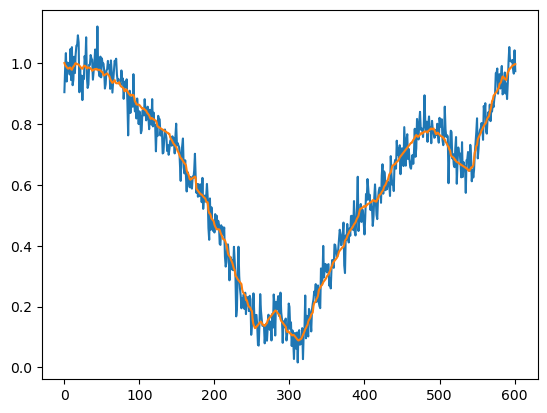

In [25]:
plt.plot(posterior_predictive_fifth['posterior_predictive']['u'][0][0][0])
plt.plot(arr_output_class5[0])
plt.show()

Synthesized and real time series for class 4

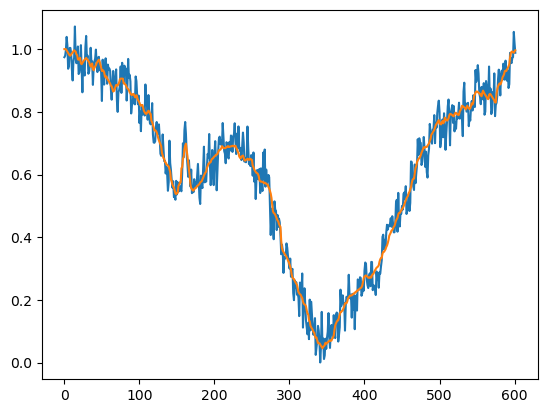

In [26]:
plt.plot(posterior_predictive_fourth['posterior_predictive']['u'][0][0][0])
plt.plot(arr_output_class4[0])
plt.show()

Synthesized and real time series for class 3

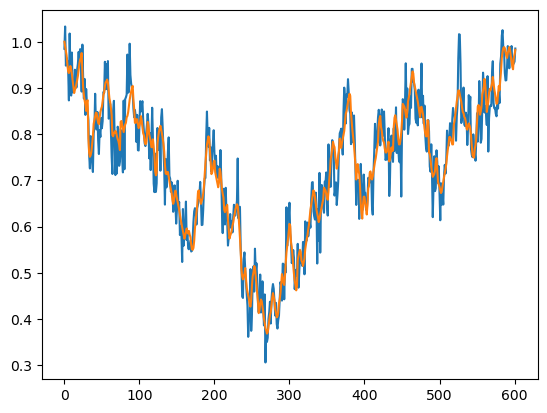

In [27]:
plt.plot(posterior_predictive_third['posterior_predictive']['u'][0][0][0])
plt.plot(arr_output_class3[0])
plt.show()

Synthesized and real time series for class 2

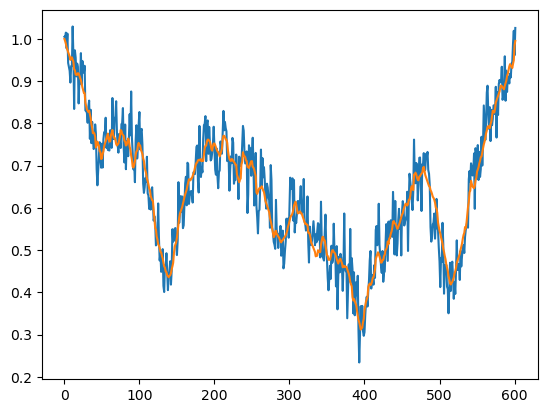

In [28]:
plt.plot(posterior_predictive_second['posterior_predictive']['u'][0][0][0])
plt.plot(arr_output_class2[0])
plt.show()

Synthesized and real time series for the class 1

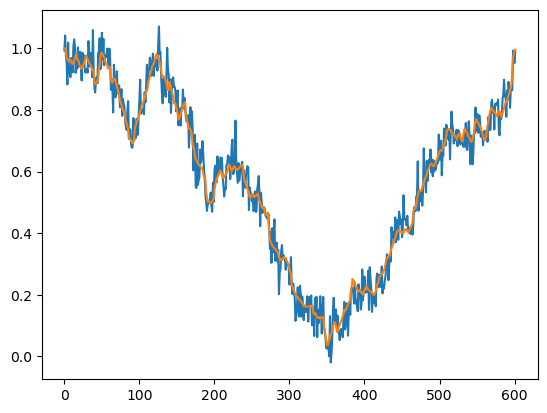

In [29]:

plt.plot(posterior_predictive['posterior_predictive']['u'][0][0][0])
plt.plot(arr_output[0])
plt.show()

**Different characteristics of generated time series (Class 1)**

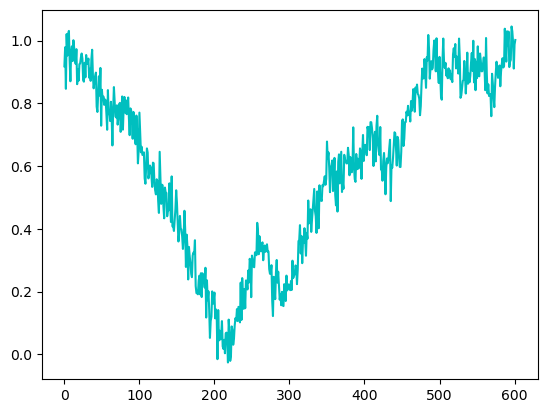

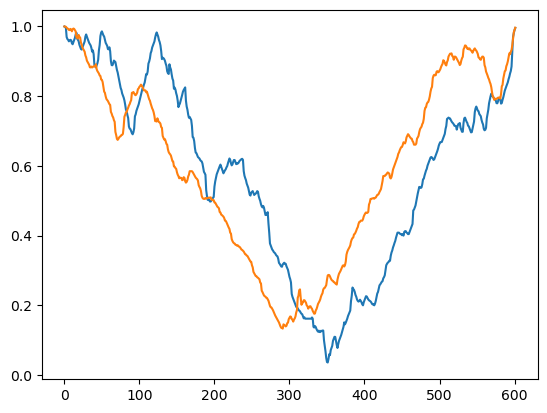

In [30]:
plt.plot(posterior_predictive['posterior_predictive']['u'][0][0][1], color=colors[6])
plt.show()

plt.plot(posterior_predictive['posterior_predictive']['u'][0][0][54], color=colors[2])
plt.show()

plt.plot(posterior_predictive['posterior_predictive']['u'][0][0][42], color=colors[3])
plt.show()

plt.plot(arr_output[0])
plt.plot(arr_output[1])
plt.show()

# Post Processing

## Moving Average

In [31]:
generated_series = posterior_predictive['posterior_predictive']['u'][0][0]
generated_series_class2 = posterior_predictive_second['posterior_predictive']['u'][0][0]
generated_series_class3 = posterior_predictive_third['posterior_predictive']['u'][0][0]
generated_series_class4 = posterior_predictive_fourth['posterior_predictive']['u'][0][0]
generated_series_class5 = posterior_predictive_fifth['posterior_predictive']['u'][0][0]

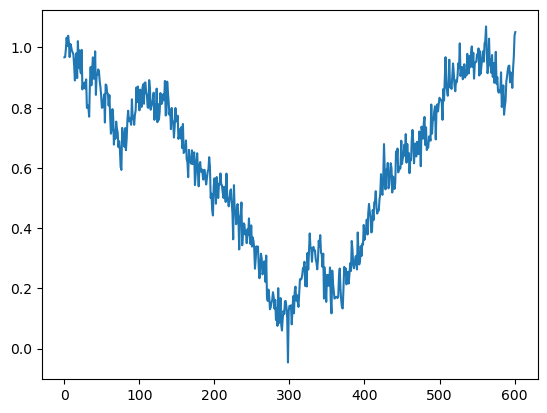

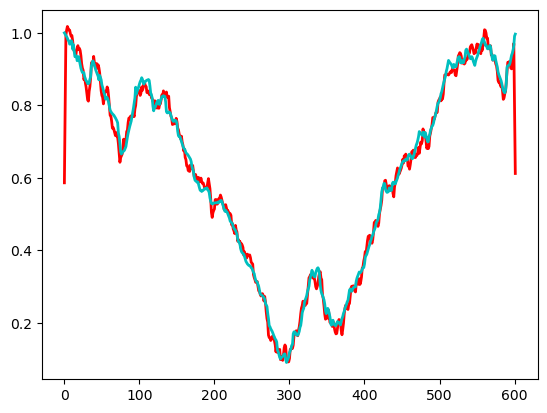

In [32]:
import numpy as np
import matplotlib.pyplot as plt

window_size = 5  # Choose a window size

# Moving average
moving_average_smoothed_series = np.convolve(generated_series[13], np.ones(window_size)/window_size, mode='same')

# Plot
plt.plot(generated_series[13], label="Original")
plt.show()
plt.plot(moving_average_smoothed_series, label="Smoothed (Moving Avg)", linewidth=2, color=colors[2])
plt.plot(normalized_samples[13], label="Real data", linewidth=2,color=colors[3])
plt.show()



## Exponential Moving Average (EMA)

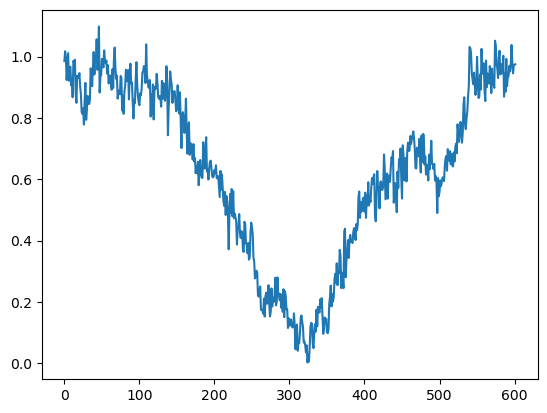

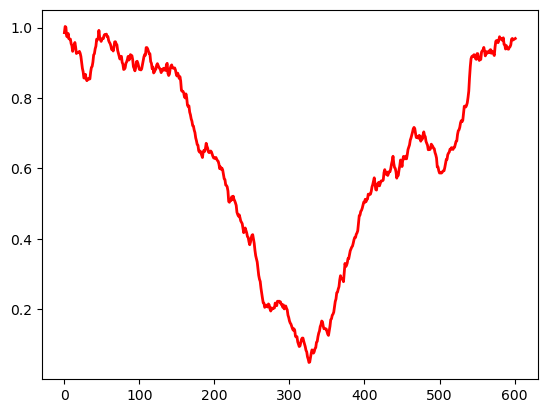

In [33]:
import pandas as pd

# Convert to pandas Series for EMA calculation
ema_generated_series = pd.Series(generated_series[60])

# Exponential moving average with a span of 10
ema_smoothed = ema_generated_series.ewm(span=10).mean()

# Plot
plt.plot(generated_series[60], label="Original")
plt.show()
plt.plot(ema_smoothed, label="Smoothed (EMA)", linewidth=2, color=colors[2])
plt.show()



In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `generated_series` is a list or NumPy array with 95 series
ema_smoothed_series = []

for i in range(len(generated_series)):  # Iterate over all series
    ema_series = pd.Series(generated_series[i]).ewm(span=10).mean()
    ema_smoothed_series.append(ema_series)
# Now `smoothed_series` contains all 95 smoothed series


In [35]:
# Assuming `generated_series` is a list or NumPy array with 95 series
ema_smoothed_series_class2 = []

for i in range(len(generated_series_class2)):  # Iterate over all series
    ema_series2 = pd.Series(generated_series_class2[i]).ewm(span=10).mean()
    ema_smoothed_series_class2.append(ema_series2)
# Now `smoothed_series` contains all 95 smoothed series

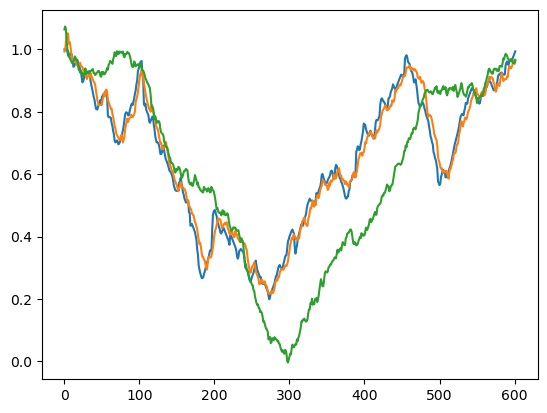

In [36]:
plt.plot(normalized_samples[78])
plt.plot(ema_smoothed_series[78])
plt.plot(ema_smoothed_series_class2[42])
plt.show()

## Savitzky-Golay Filter

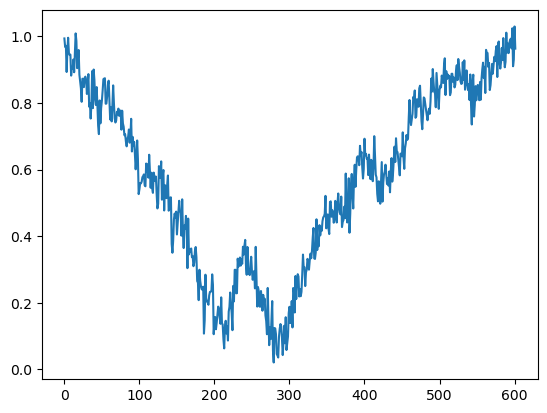

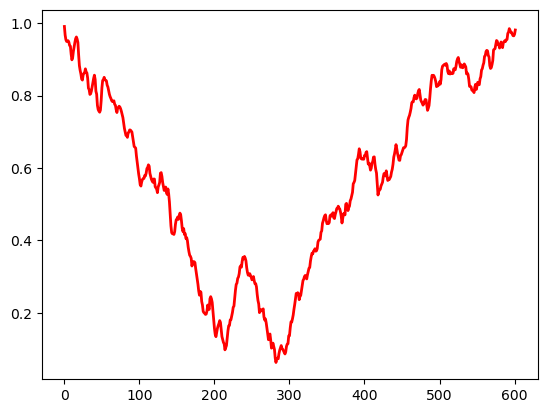

In [37]:
from scipy.signal import savgol_filter

# Savitzky-Golay filter
savitzky_smoothed_series = savgol_filter(generated_series, window_length=11, polyorder=3)  # Adjust window_length

# Plot
plt.plot(generated_series[76], label="Original")
plt.show()
plt.plot(savitzky_smoothed_series[76], label="Smoothed (Savitzky-Golay)", linewidth=2, color=colors[2])
plt.show()


## Wavelet Denoising

In [38]:
!pip install PyWavelets

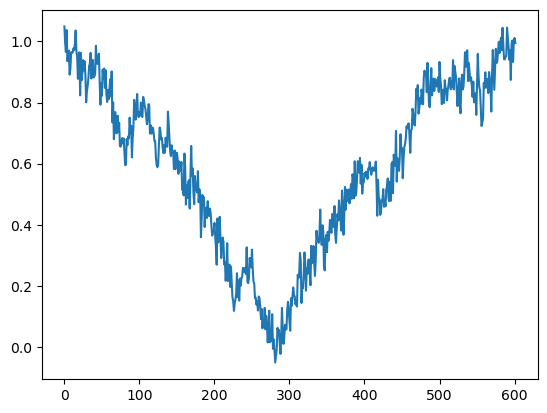

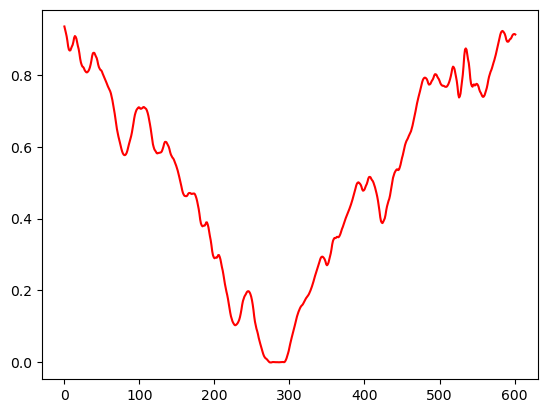

In [39]:
from statsmodels.robust import mad
import pywt
import pywt.data
gen_series = posterior_predictive['posterior_predictive']['u'][0][0]

def wavelet_denoise(series, wavelet='db4', level=3, threshold=0.2):
    # Decompose the series using Discrete Wavelet Transform
    coeffs = pywt.wavedec(series, wavelet, level=level)

    # Apply soft thresholding to suppress noise
    coeffs_denoised = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

    # Reconstruct the denoised time series
    denoised_series = pywt.waverec(coeffs_denoised, wavelet)

    # Ensure output length matches input
    return denoised_series[:len(series)]

wavelet_series = [wavelet_denoise(series) for series in gen_series]

plt.plot(generated_series[54], label='Original')
plt.show()
plt.plot(wavelet_series[54], label='Smoothed', color = colors[2])
plt.show()

## Low-pass Filtering

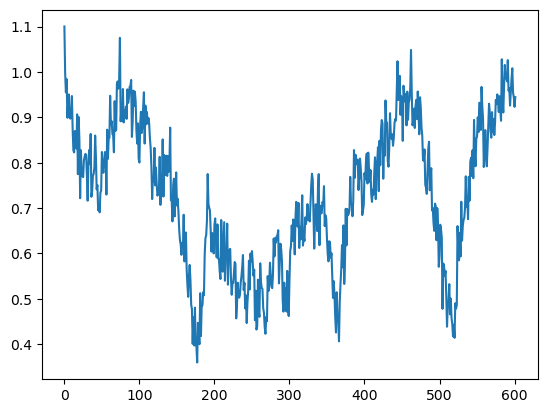

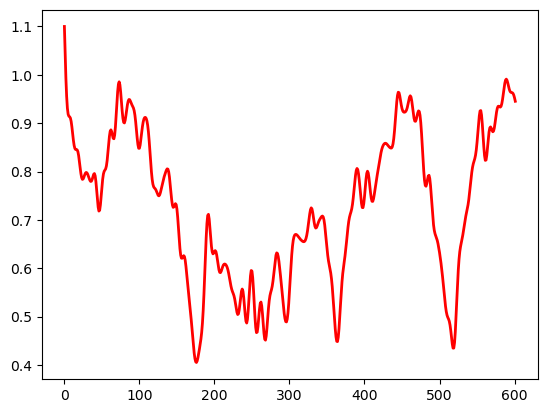

In [40]:
from scipy.signal import butter, filtfilt


# Design a low-pass Butterworth filter
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Apply the filter
cutoff = 0.1  # Cutoff frequency
fs = 1.0  # Sampling rate
lowpass_smoothed_series = butter_lowpass_filter(generated_series, cutoff, fs)

# Plot
plt.plot(generated_series[37], label="Original")
plt.show()
plt.plot(lowpass_smoothed_series[37], label="Smoothed (Low-pass Filter)", linewidth=2, color=colors[2])
plt.show()



# Evaluation Metrics


**Defining the evaluation metrics and comparing it between original to pseudo and original to original time series**

## Mean Absolute Error (MAE)

In [41]:
from sklearn.metrics import mean_absolute_error
import scipy.stats
from sklearn.metrics import mean_squared_error
from math import sqrt

mae = mean_absolute_error(arr_output[0], gen_series[0])
maeWave = mean_absolute_error(arr_output[0], wavelet_series[0])
maeMas = mean_absolute_error(arr_output[0], moving_average_smoothed_series)
maeEma = mean_absolute_error(arr_output[0], ema_smoothed)
maeSavitzky = mean_absolute_error(arr_output[0], savitzky_smoothed_series[0])
maeLowpass = mean_absolute_error(arr_output[0], lowpass_smoothed_series[0])
maeOrg = mean_absolute_error(arr_output[1], arr_output[2])

print(f'MAE of original and original: {maeOrg}')
print(f'MAE of original and generated: {mae}')
print(f'MAE of after Wavelet: {maeWave}')
print(f'MAE of after moving average smoothed: {maeMas}')
print(f'MAE of after EMA: {maeEma}')
print(f'MAE of after Savitzky: {maeSavitzky}')
print(f'MAE of after Low-pass Filtering: {maeLowpass}')

MAE of original and original: 0.05313925600190156
MAE of original and generated: 0.03322729712325014
MAE of after Wavelet: 0.0693432133667741
MAE of after moving average smoothed: 0.1330696414897074
MAE of after EMA: 0.11654671053595966
MAE of after Savitzky: 0.017932752655907623
MAE of after Low-pass Filtering: 0.017561780848947658


## Root Mean Squared Error(RMSE)

In [42]:
rmse = numpy.sqrt(mean_squared_error(arr_output[0], gen_series[0]))
rmsWave = numpy.sqrt(mean_squared_error(arr_output[0], wavelet_series[0]))
rmseMas = numpy.sqrt(mean_squared_error(arr_output[0], moving_average_smoothed_series))
rmseEma = numpy.sqrt(mean_squared_error(arr_output[0], ema_smoothed))
rmseSavitzky = numpy.sqrt(mean_squared_error(arr_output[0], savitzky_smoothed_series[0]))
rmseLowpass = numpy.sqrt(mean_squared_error(arr_output[0], lowpass_smoothed_series[0]))
rmseOrg = numpy.sqrt(mean_squared_error(arr_output[1], arr_output[2]))

print(f'RMSE of original and original: {rmseOrg}')
print(f'RMSE of original and generated: {rmse}')
print(f'RMSE of after Wavelet: {rmsWave}')
print(f'RMSE of after moving average smoothed: {rmseMas}')
print(f'RMSE of after EMA: {rmseEma}')
print(f'RMSE of after Savitzky: {rmseSavitzky}')
print(f'RMSE of after Low-pass Filtering: {rmseLowpass}')


RMSE of original and original: 0.06566763970856734
RMSE of original and generated: 0.04188969103610977
RMSE of after Wavelet: 0.07183798642728025
RMSE of after moving average smoothed: 0.15341238943262958
RMSE of after EMA: 0.14347684721872195
RMSE of after Savitzky: 0.022059969565165437
RMSE of after Low-pass Filtering: 0.021470664551586423


## Pearson Correlation

In [43]:
pearson_corr = numpy.corrcoef(arr_output[0], gen_series[0])[0, 1]
pearson_corr_wave = numpy.corrcoef(arr_output[0], wavelet_series[0])[0, 1]
pearson_corr_mas = numpy.corrcoef(arr_output[0], moving_average_smoothed_series)[0, 1]
pearson_corr_ema = numpy.corrcoef(arr_output[0], ema_smoothed)[0, 1]
pearson_corr_Savitzky = numpy.corrcoef(arr_output[0], savitzky_smoothed_series[0])[0, 1]
pearson_corr_Lowpass = numpy.corrcoef(arr_output[0], lowpass_smoothed_series[0])[0, 1]
pearson_corr_org = numpy.corrcoef(arr_output[1], arr_output[2])[0, 1]

print(f'Pearson Correlation of original and original: {pearson_corr_org}')
print(f'Pearson Correlation of original and generated: {pearson_corr}')
print(f'Pearson Correlation of after Wavelet: {pearson_corr_wave}')
print(f'Pearson Correlation of after moving average smoothed: {pearson_corr_mas}')
print(f'Pearson Correlation of after EMA: {pearson_corr_ema}')
print(f'Pearson Correlation of after Savitzky: {pearson_corr_Savitzky}')
print(f'Pearson Correlation of after Low-pass Filtering: {pearson_corr_Lowpass}')


Pearson Correlation of original and original: 0.9692844196274872
Pearson Correlation of original and generated: 0.9889846885594367
Pearson Correlation of after Wavelet: 0.9977765066070883
Pearson Correlation of after moving average smoothed: 0.8443052103286529
Pearson Correlation of after EMA: 0.8815219071555925
Pearson Correlation of after Savitzky: 0.9969960436579617
Pearson Correlation of after Low-pass Filtering: 0.9971489812913715


## Spearman Correlation

In [44]:
spearman_corr, _ = scipy.stats.spearmanr(arr_output[0], gen_series[0])
spearman_corr_wave, _ = scipy.stats.spearmanr(arr_output[0], wavelet_series[0])
spearman_corr_mas, _ = scipy.stats.spearmanr(arr_output[0], moving_average_smoothed_series)
spearman_corr_ema, _ = scipy.stats.spearmanr(arr_output[0], ema_smoothed)
spearman_corr_Savitzky, _ = scipy.stats.spearmanr(arr_output[0], savitzky_smoothed_series[0])
spearman_corr_Lowpass, _ = scipy.stats.spearmanr(arr_output[0], lowpass_smoothed_series[0])
spearman_corr_org, _ = scipy.stats.spearmanr(arr_output[1], arr_output[2])

print(f'Spearman Correlation of original and original: {spearman_corr_org}')
print(f'Spearman Correlation of original and generated: {spearman_corr}')
print(f'Spearman Correlation of after Wavelet: {spearman_corr_wave}')
print(f'Spearman Correlation of after moving average smoothed: {spearman_corr_mas}')
print(f'Spearman Correlation of after EMA: {spearman_corr_ema}')
print(f'Spearman Correlation of after Savitzky: {spearman_corr_Savitzky}')
print(f'Spearman Correlation of after Low-pass Filtering: {spearman_corr_Lowpass}')

Spearman Correlation of original and original: 0.9684524946852607
Spearman Correlation of original and generated: 0.9856816552011644
Spearman Correlation of after Wavelet: 0.9963542130864469
Spearman Correlation of after moving average smoothed: 0.8262123291067138
Spearman Correlation of after EMA: 0.8907304462665488
Spearman Correlation of after Savitzky: 0.9949869518924026
Spearman Correlation of after Low-pass Filtering: 0.9951517712896852


## SQL (Scaled Quantile Loss)



In [45]:
def scaled_quantile_loss(y_true, y_pred, quantile):
    numerator = np.sum((y_true - y_pred) * (quantile - (y_true < y_pred)))
    denominator = np.sum(np.abs(y_true))
    return 2 * numerator / denominator

# Example usage:
quantile = 0.5  # 50th percentile (median)
sql = scaled_quantile_loss(arr_output[0], gen_series[0], quantile)
sql_wave = scaled_quantile_loss(arr_output[0], wavelet_series[0], quantile)
sql_mas = scaled_quantile_loss(arr_output[0], moving_average_smoothed_series, quantile)
sql_ema = scaled_quantile_loss(arr_output[0], ema_smoothed, quantile)
sql_Sav = scaled_quantile_loss(arr_output[0], savitzky_smoothed_series[0], quantile)
sql_Lowpass = scaled_quantile_loss(arr_output[0], lowpass_smoothed_series[0], quantile)
sql_org = scaled_quantile_loss(arr_output[1], arr_output[2], quantile)

quantiles = [0.1, 0.5, 0.9]
for q in quantiles:
    sql = scaled_quantile_loss(arr_output[0], gen_series[0], q)
    print(f'SQL of original and generated for quantile {q}: {sql}')

    sql_wave = scaled_quantile_loss(arr_output[0], wavelet_series[0], q)
    sql_mas = scaled_quantile_loss(arr_output[0], moving_average_smoothed_series, q)
    sql_ema = scaled_quantile_loss(arr_output[0], ema_smoothed, q)
    sql_Sav = scaled_quantile_loss(arr_output[0], savitzky_smoothed_series[0], q)
    sql_Lowpass = scaled_quantile_loss(arr_output[0], lowpass_smoothed_series[0], q)
    sql_org = scaled_quantile_loss(arr_output[1], arr_output[2], q)


    print(f'SQL of after original to original for quantile {q}: {sql_org}')
    print(f'SQL of after Wavelet for quantile {q}: {sql_wave}')
    print(f'SQL of after moving average smoothed for quantile {q}: {sql_mas}')
    print(f'SQL of after EMA for quantile {q}: {sql_ema}')
    print(f'SQL of after Savitzky for quantile {q}: {sql_Sav}')
    print(f'SQL of after Low-pass Filtering for quantile {q}: {sql_Lowpass}')


SQL of original and generated for quantile 0.1: <xarray.DataArray 'u' ()>
array(0.05825008)
Coordinates:
    chain    int32 0
    draw     int32 0
    u_dim_0  int32 0
SQL of after original to original for quantile 0.1: 0.07093918008610514
SQL of after Wavelet for quantile 0.1: 0.023823891428844987
SQL of after moving average smoothed for quantile 0.1: 0.2664012942104609
SQL of after EMA for quantile 0.1: 0.26689355143753724
SQL of after Savitzky for quantile 0.1: 0.032002200481191526
SQL of after Low-pass Filtering for quantile 0.1: 0.03122783485214122
SQL of original and generated for quantile 0.5: <xarray.DataArray 'u' ()>
array(0.05707866)
Coordinates:
    chain    int32 0
    draw     int32 0
    u_dim_0  int32 0
SQL of after original to original for quantile 0.5: 0.08848339012398752
SQL of after Wavelet for quantile 0.5: 0.11911945714422496
SQL of after moving average smoothed for quantile 0.5: 0.22859026409390043
SQL of after EMA for quantile 0.5: 0.20020677175079815
SQL of afte

## Dynamic Time Warping (DTW)

In [46]:
!pip install fastdtw

  Using cached fastdtw-0.3.4-py3-none-any.whl


In [47]:
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean


y_true = np.array(arr_output[0], dtype=float).ravel()
y_pred = np.array([item.values if hasattr(item, 'values') else item for item in gen_series[0]], dtype=float)


y_wavelet = np.array(wavelet_series[0], dtype=float).ravel()
y_moving_avg = np.array(moving_average_smoothed_series, dtype=float).ravel()
y_ema = np.array(ema_smoothed, dtype=float).ravel()
y_savitzky = np.array(savitzky_smoothed_series[0], dtype=float).ravel()
y_lowpass = np.array(lowpass_smoothed_series[0], dtype=float).ravel()

y_org = np.array(arr_output[1], dtype=float).ravel()
y_org2 = np.array(arr_output[2], dtype=float).ravel()


def compute_dtw(y_true, y_pred):
    y_true = np.nan_to_num(y_true)
    y_pred = np.nan_to_num(y_pred)
    y_true = np.ascontiguousarray(y_true)
    y_pred = np.ascontiguousarray(y_pred)

    
    distance, _ = fastdtw(y_true, y_pred, dist=lambda x, y: (x - y) ** 2)
    return distance


dtw_original = compute_dtw(y_true, y_pred)
dtw_wavelet = compute_dtw(y_true, y_wavelet)
dtw_moving_avg = compute_dtw(y_true, y_moving_avg)
dtw_ema = compute_dtw(y_true, y_ema)
dtw_savitzky = compute_dtw(y_true, y_savitzky)
dtw_lowpass = compute_dtw(y_true, y_lowpass)
data_org = compute_dtw(y_org, y_org2)


print(f'DTW Distance (Original): {dtw_original}')
print(f'DTW Distance (Synthetic): {data_org}')
print(f'DTW Distance (Wavelet Denoised): {dtw_wavelet}')
print(f'DTW Distance (Moving Average Smoothed): {dtw_moving_avg}')
print(f'DTW Distance (Exponential Moving Average): {dtw_ema}')
print(f'DTW Distance (Savitzky-Golay Filter): {dtw_savitzky}')
print(f'DTW Distance (Low-pass Filter): {dtw_lowpass}')


DTW Distance (Original): 0.7608609786490784
DTW Distance (Synthetic): 0.36462433889493656
DTW Distance (Wavelet Denoised): 0.37591047321481036
DTW Distance (Moving Average Smoothed): 1.03304260310956
DTW Distance (Exponential Moving Average): 0.7417532159645384
DTW Distance (Savitzky-Golay Filter): 0.07935447824208436
DTW Distance (Low-pass Filter): 0.06837235265064137


## Time-Weighted Dynamic Time Warping (TDTW)

In [48]:
import numpy as np
from fastdtw import fastdtw

def time_weight(t, length, mode='linear'):
    if mode == 'linear':
        return 1 - (t / length)
    elif mode == 'exponential':
        return np.exp(-t / length)
    elif mode == 'custom':
        return np.sin((t / length) * np.pi)
    else:
        raise ValueError(f"Unknown mode: {mode}")

def weighted_distance(x, y, t, length, mode='linear'):
    weight = time_weight(t, length, mode)
    return weight * np.abs(x - y)  # Absolute difference (like L1 distance)

def time_weighted_dtw(y_true, y_pred, mode='linear'):
    length = len(y_true)
    distance, path = fastdtw(
        y_true,
        y_pred,
        dist=lambda x, y: weighted_distance(x, y, t=min(x, y), length=length, mode=mode)
    )
    return distance, path


y_true = np.array(arr_output[0], dtype=float).ravel()

# Postprocessed series
y_pred = np.array([item.values if hasattr(item, 'values') else item for item in gen_series[0]], dtype=float)
y_wavelet = np.array(wavelet_series[0], dtype=float).ravel()
y_moving_avg = np.array(moving_average_smoothed_series, dtype=float).ravel()
y_ema = np.array(ema_smoothed, dtype=float).ravel()
y_savitzky = np.array(savitzky_smoothed_series[0], dtype=float).ravel()
y_lowpass = np.array(lowpass_smoothed_series[0], dtype=float).ravel()
y_org = np.array(arr_output[1], dtype=float).ravel()
y_org2 = np.array(arr_output[2], dtype=float).ravel()

# Compute TDTW distances
tdtw_original, _ = time_weighted_dtw(y_true, y_pred, mode='linear')
tdtw_wavelet, _ = time_weighted_dtw(y_true, y_wavelet, mode='linear')
tdtw_moving_avg, _ = time_weighted_dtw(y_true, y_moving_avg, mode='linear')
tdtw_ema, _ = time_weighted_dtw(y_true, y_ema, mode='linear')
tdtw_savitzky, _ = time_weighted_dtw(y_true, y_savitzky, mode='linear')
tdtw_lowpass, _ = time_weighted_dtw(y_true, y_lowpass, mode='linear')
tdtw_org, _ = time_weighted_dtw(y_org, y_org2, mode='linear')


print(f'TDTW Distance (Original): {tdtw_org}')
print(f'TDTW Distance (Synthetic): {tdtw_original}')
print(f'TDTW Distance (Wavelet Denoised): {tdtw_wavelet}')
print(f'TDTW Distance (Moving Average Smoothed): {tdtw_moving_avg}')
print(f'TDTW Distance (Exponential Moving Average): {tdtw_ema}')
print(f'TDTW Distance (Savitzky-Golay Filter): {tdtw_savitzky}')
print(f'TDTW Distance (Low-pass Filter): {tdtw_lowpass}')


TDTW Distance (Original): 10.023406906005825
TDTW Distance (Synthetic): 17.433769422569917
TDTW Distance (Wavelet Denoised): 11.506963864417438
TDTW Distance (Moving Average Smoothed): 14.338470083877668
TDTW Distance (Exponential Moving Average): 13.060026323903235
TDTW Distance (Savitzky-Golay Filter): 5.771920753157353
TDTW Distance (Low-pass Filter): 5.220374435156398


## Hausdorff Distance

In [49]:
!pip install frechetdist

  Using cached frechetdist-0.6-py3-none-any.whl.metadata (2.7 kB)
Using cached frechetdist-0.6-py3-none-any.whl (7.6 kB)


In [50]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff


def compute_hausdorff(y_true, y_pred):
    return directed_hausdorff(y_true.reshape(-1, 1), y_pred.reshape(-1, 1))[0]

y_true = np.array(arr_output[0], dtype=float).ravel()

# Postprocessed series
y_wavelet = np.array(wavelet_series[0], dtype=float).ravel()
y_moving_avg = np.array(moving_average_smoothed_series, dtype=float).ravel()
y_ema = np.array(ema_smoothed, dtype=float).ravel()
y_savitzky = np.array(savitzky_smoothed_series[0], dtype=float).ravel()
y_lowpass = np.array(lowpass_smoothed_series[0], dtype=float).ravel()
y_org = np.array(arr_output[1], dtype=float).ravel()
y_org2 = np.array(arr_output[2], dtype=float).ravel()


hausdorff_original = compute_hausdorff(y_true, y_pred)
hausdorff_wavelet = compute_hausdorff(y_true, y_wavelet)
hausdorff_moving_avg = compute_hausdorff(y_true, y_moving_avg)
hausdorff_ema = compute_hausdorff(y_true, y_ema)
hausdorff_savitzky = compute_hausdorff(y_true, y_savitzky)
hausdorff_lowpass = compute_hausdorff(y_true, y_lowpass)
hausdorff_org = compute_hausdorff(y_org, y_org2)

print(f'Hausdorff Distance (Original): {hausdorff_org}')
print(f'Hausdorff Distance (Synthetic): {hausdorff_original}')
print(f'Hausdorff Distance (Wavelet Denoised): {hausdorff_wavelet}')
print(f'Hausdorff Distance (Moving Average Smoothed): {hausdorff_moving_avg}')
print(f'Hausdorff Distance (Exponential Moving Average): {hausdorff_ema}')
print(f'Hausdorff Distance (Savitzky-Golay Filter): {hausdorff_savitzky}')
print(f'Hausdorff Distance (Low-pass Filter): {hausdorff_lowpass}')


Hausdorff Distance (Original): 0.00843477537437487
Hausdorff Distance (Synthetic): 0.0063163848190586624
Hausdorff Distance (Wavelet Denoised): 0.07631146665862332
Hausdorff Distance (Moving Average Smoothed): 0.055789642866600896
Hausdorff Distance (Exponential Moving Average): 0.012772599888407302
Hausdorff Distance (Savitzky-Golay Filter): 0.007778800190085956
Hausdorff Distance (Low-pass Filter): 0.006999072081661138


## Fretchet Distance

In [51]:
import numpy as np
from frechetdist import frdist


def compute_frechet(y_true, y_pred):
    
    p = [(t, y) for t, y in enumerate(y_true)]
    q = [(t, y) for t, y in enumerate(y_pred)]
    return frdist(p, q)


y_true = np.array(arr_output[0], dtype=float).ravel()

# Postprocessed series
y_wavelet = np.array(wavelet_series[0], dtype=float).ravel()
y_moving_avg = np.array(moving_average_smoothed_series, dtype=float).ravel()
y_ema = np.array(ema_smoothed, dtype=float).ravel()
y_savitzky = np.array(savitzky_smoothed_series[0], dtype=float).ravel()
y_lowpass = np.array(lowpass_smoothed_series[0], dtype=float).ravel()
y_org = np.array(arr_output[1], dtype=float).ravel()
y_org2 = np.array(arr_output[2], dtype=float).ravel()

# Compute Fréchet distance
frechet_original = compute_frechet(y_true, y_pred)
frechet_wavelet = compute_frechet(y_true, y_wavelet)
frechet_moving_avg = compute_frechet(y_true, y_moving_avg)
frechet_ema = compute_frechet(y_true, y_ema)
frechet_savitzky = compute_frechet(y_true, y_savitzky)
frechet_lowpass = compute_frechet(y_true, y_lowpass)
frechet_org = compute_frechet(y_org, y_org2)


print(f'Fréchet Distance (Original): {frechet_org}')
print(f'Fréchet Distance (Synthetic): {frechet_original}')
print(f'Fréchet Distance (Wavelet Denoised): {frechet_wavelet}')
print(f'Fréchet Distance (Moving Average Smoothed): {frechet_moving_avg}')
print(f'Fréchet Distance (Exponential Moving Average): {frechet_ema}')
print(f'Fréchet Distance (Savitzky-Golay Filter): {frechet_savitzky}')
print(f'Fréchet Distance (Low-pass Filter): {frechet_lowpass}')


Fréchet Distance (Original): 0.1882
Fréchet Distance (Synthetic): 0.15455371463278078
Fréchet Distance (Wavelet Denoised): 0.1185469908786266
Fréchet Distance (Moving Average Smoothed): 0.41380124561854403
Fréchet Distance (Exponential Moving Average): 0.37319385465547245
Fréchet Distance (Savitzky-Golay Filter): 0.05692405583888849
Fréchet Distance (Low-pass Filter): 0.05062842531955303


## Cross-Correlation Function (CCF)

In [52]:
!pip install statsmodels

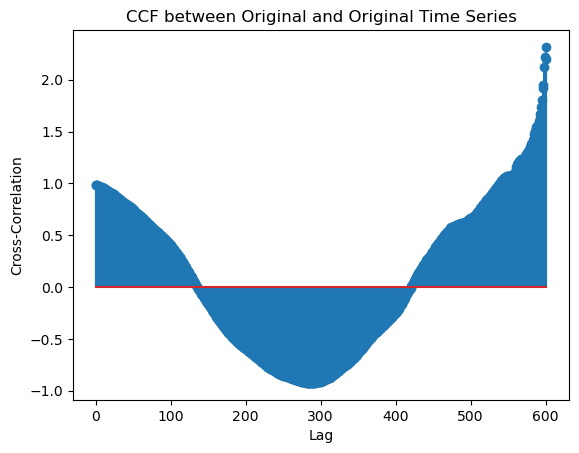

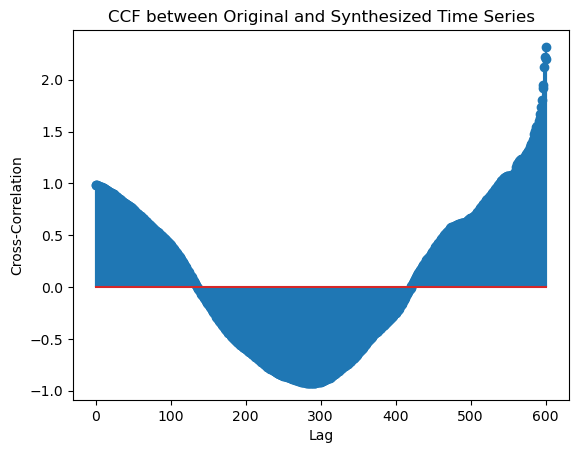

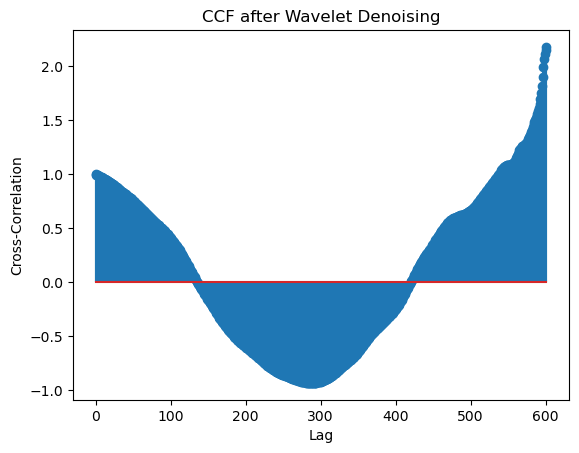

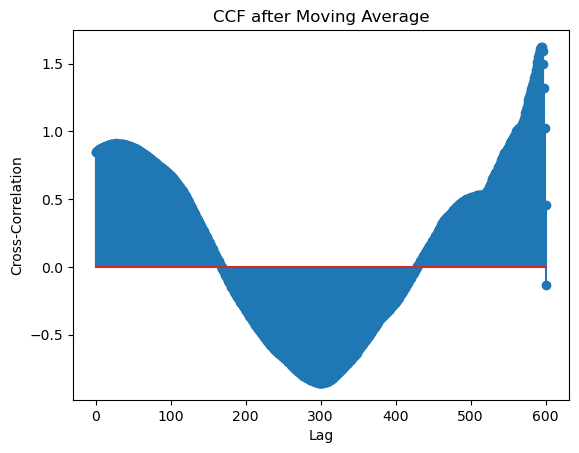

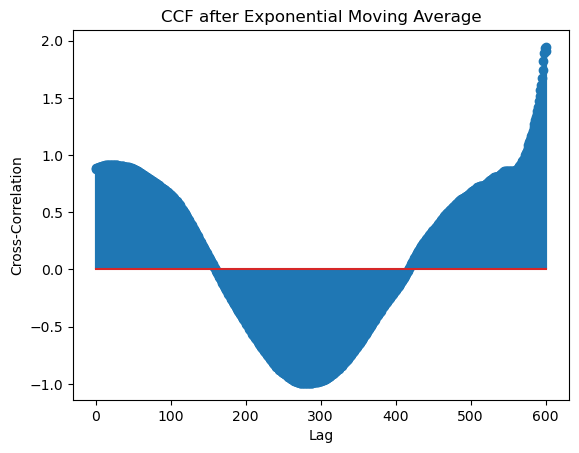

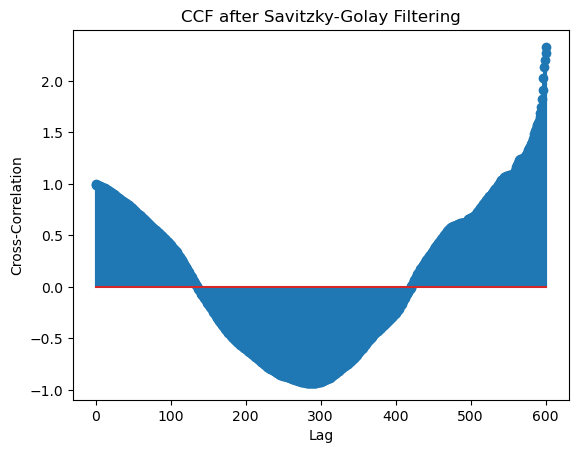

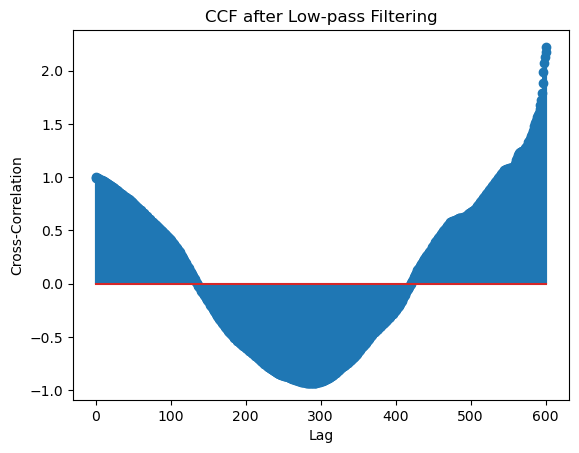

array([ 0.99714898,  0.99449706,  0.99129757,  0.98766891,  0.98398303,
        0.98023239,  0.97653239,  0.9729927 ,  0.96957331,  0.96623491,
        0.96291681,  0.95957967,  0.95607089,  0.95224249,  0.94807181,
        0.94358084,  0.9388079 ,  0.93387265,  0.92907045,  0.92431686,
        0.91961429,  0.91496905,  0.9102666 ,  0.90543407,  0.90039532,
        0.89507477,  0.88951508,  0.88378766,  0.87796841,  0.87203434,
        0.86609688,  0.86028002,  0.85456149,  0.84891973,  0.84333567,
        0.83778393,  0.83226235,  0.82682001,  0.82150023,  0.8161725 ,
        0.81098229,  0.80611166,  0.80128742,  0.79646145,  0.79150877,
        0.7863716 ,  0.78095783,  0.77503849,  0.76869562,  0.76181812,
        0.7546079 ,  0.74721256,  0.73983701,  0.73259599,  0.72555837,
        0.71881768,  0.71237285,  0.70610661,  0.69991966,  0.69375739,
        0.68744062,  0.68084321,  0.67411427,  0.66745119,  0.66071949,
        0.65385098,  0.64682643,  0.63962941,  0.63237833,  0.62

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

# Convert time series to 1D arrays
y_true = np.array(arr_output[0], dtype=float).ravel()

# Postprocessed series
y_pred = np.array([item.values if hasattr(item, 'values') else item for item in gen_series[0]], dtype=float)
y_wavelet = np.array(wavelet_series[0], dtype=float).ravel()
y_moving_avg = np.array(moving_average_smoothed_series, dtype=float).ravel()
y_ema = np.array(ema_smoothed, dtype=float).ravel()
y_savitzky = np.array(savitzky_smoothed_series[0], dtype=float).ravel()
y_lowpass = np.array(lowpass_smoothed_series[0], dtype=float).ravel()
y_org = np.array(arr_output[1], dtype=float).ravel()
y_org2 = np.array(arr_output[2], dtype=float).ravel()

# Function to compute and plot CCF
def compute_ccf(y_true, y_pred, title="Cross-Correlation Function (CCF)"):
    cross_corr = ccf(y_true, y_pred)

    plt.stem(cross_corr)
    plt.xlabel('Lag')
    plt.ylabel('Cross-Correlation')
    plt.title(title)
    plt.show()
    return cross_corr

compute_ccf(y_true, y_pred, title="CCF between Original and Original Time Series")
compute_ccf(y_true, y_pred, title="CCF between Original and Synthesized Time Series")
compute_ccf(y_true, y_wavelet, title="CCF after Wavelet Denoising")
compute_ccf(y_true, y_moving_avg, title="CCF after Moving Average")
compute_ccf(y_true, y_ema, title="CCF after Exponential Moving Average")
compute_ccf(y_true, y_savitzky, title="CCF after Savitzky-Golay Filtering")
compute_ccf(y_true, y_lowpass, title="CCF after Low-pass Filtering")


In [54]:
pip install --upgrade jax jaxlib

  Using cached jax-0.6.0-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.6.0-cp312-cp312-win_amd64.whl.metadata (1.2 kB)
  Using cached ml_dtypes-0.5.1-cp312-cp312-win_amd64.whl.metadata (22 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
Using cached jax-0.6.0-py3-none-any.whl (2.3 MB)
Using cached jaxlib-0.6.0-cp312-cp312-win_amd64.whl (56.4 MB)
Using cached ml_dtypes-0.5.1-cp312-cp312-win_amd64.whl (210 kB)
Using cached opt_einsum-3.4.0-py3-none-any.whl (71 kB)
Note: you may need to restart the kernel to use updated packages.


In [55]:
pip install tensorflow

  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl (376.0 MB)
Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
Using cached flatbuffers-25.2.10-py2.py3-none-any.whl (30 kB)
Using cached gast-0.6.0-py3-none-any.whl (21 kB)
Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   ------- -------------------------------- 0.8/4.3 M

# Synthesized time series analysis through classifiers

## SVM

**SVM results**

In [56]:

ema_smoothed_series_class2 = np.array(ema_smoothed_series_class2)
ema_smoothed_series = np.array(ema_smoothed_series)



=== Real-trained on Real test ===
              precision    recall  f1-score   support

           0      0.462     0.632     0.533        19
           1      0.000     0.000     0.000        15
           2      0.375     0.632     0.471        19
           3      0.556     0.556     0.556        18
           4      0.000     0.000     0.000         5

    accuracy                          0.447        76
   macro avg      0.278     0.364     0.312        76
weighted avg      0.341     0.447     0.383        76


=== Real-trained on Synth test ===
              precision    recall  f1-score   support

           0      0.444     0.632     0.522        19
           1      0.000     0.000     0.000        15
           2      0.375     0.632     0.471        19
           3      0.588     0.556     0.571        18
           4      0.000     0.000     0.000         5

    accuracy                          0.447        76
   macro avg      0.282     0.364     0.313        76
weight

C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packag

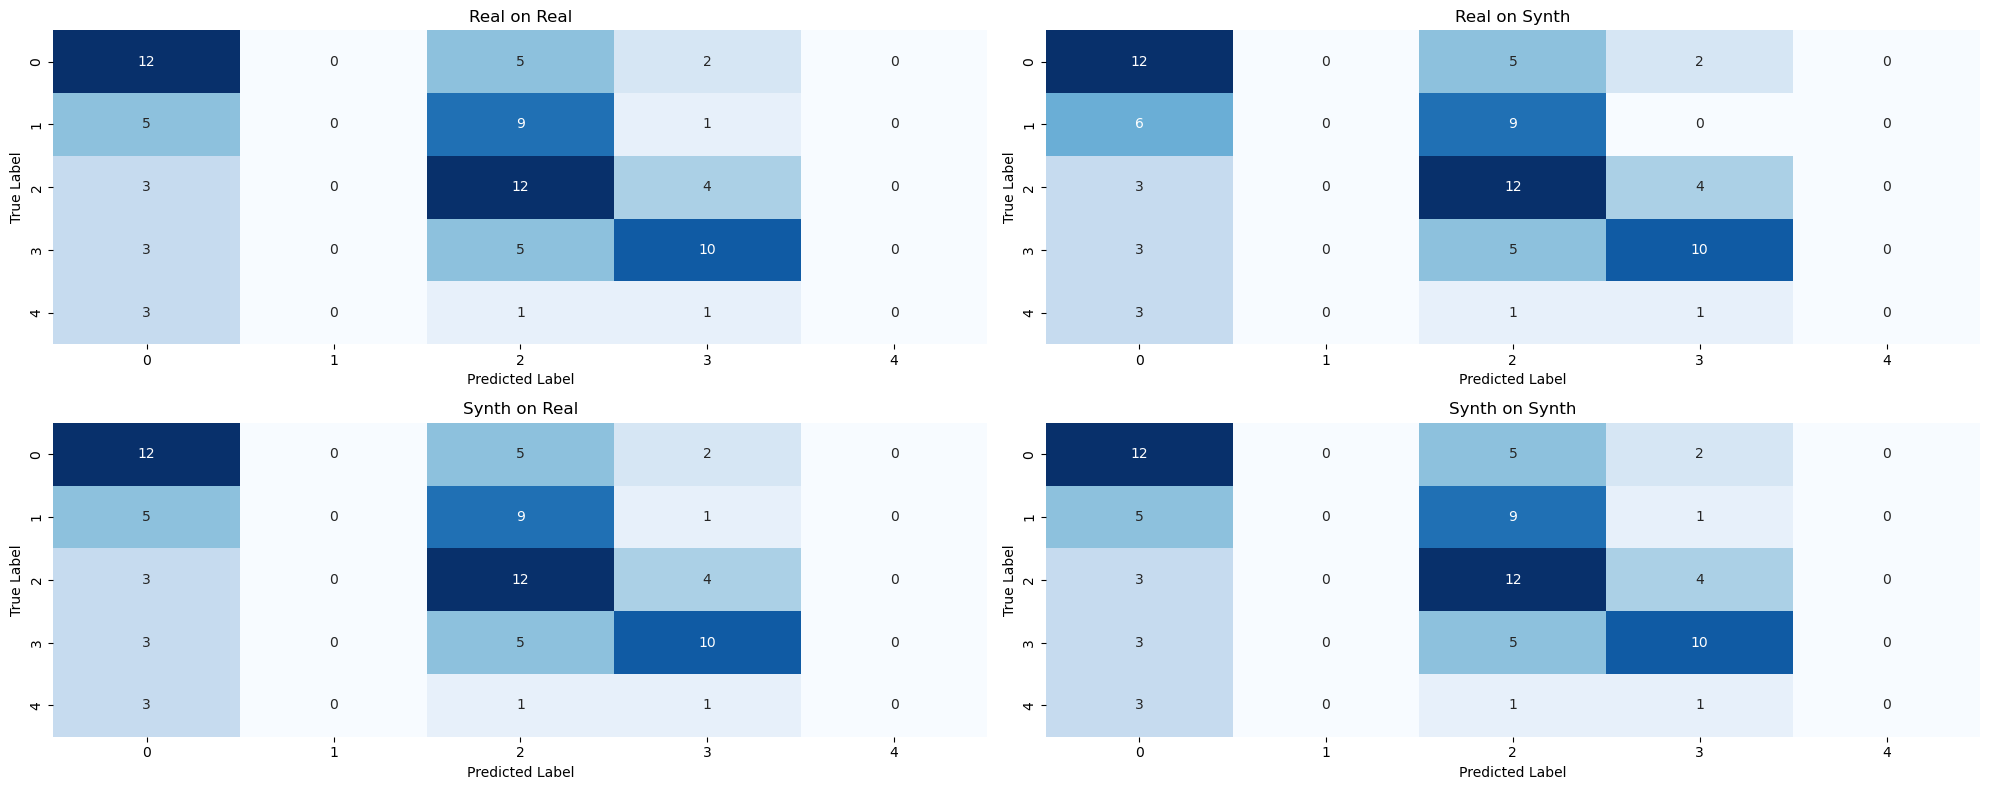

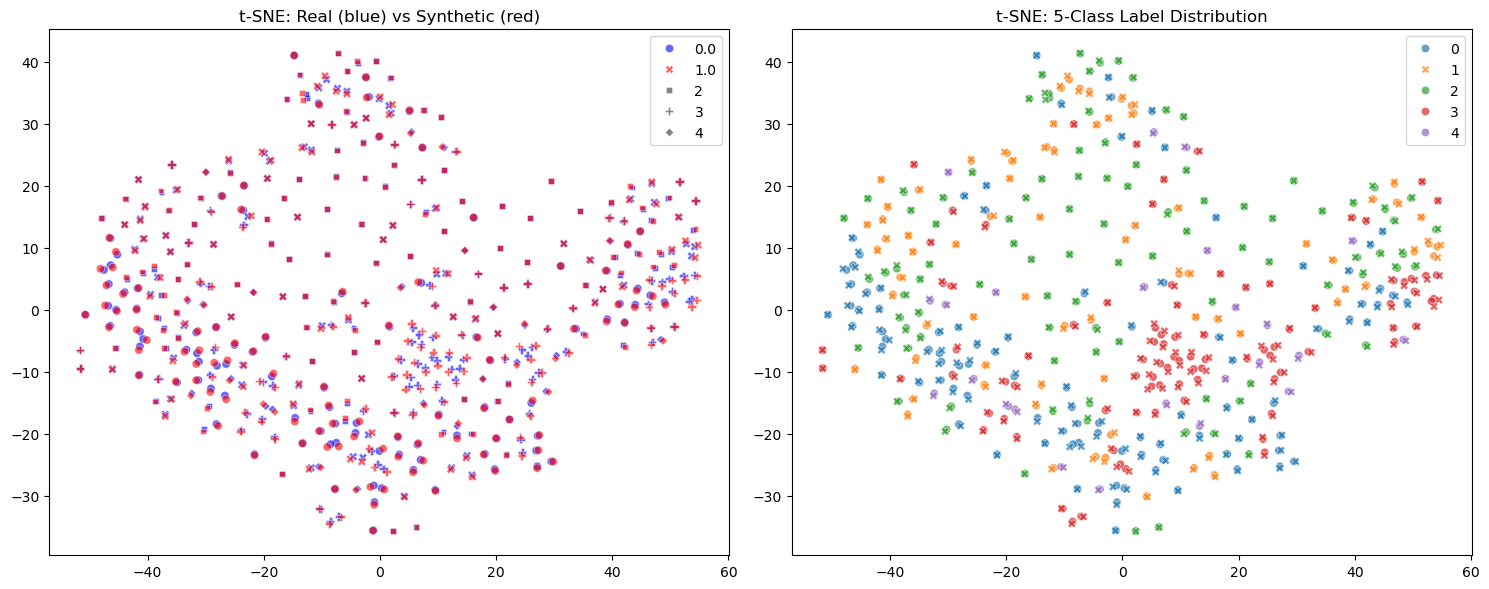

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.manifold import TSNE

# -------------------------
# 1. Prepare Data
# -------------------------

# Real data (5 classes)
X_real = np.vstack([
    normalized_samples,
    normalized_samples_secondClass,
    normalized_samples_thirdClass,
    normalized_samples_fourthClass,
    normalized_samples_fifthClass
])
y_real = np.hstack([
    np.full(len(normalized_samples), 0),
    np.full(len(normalized_samples_secondClass), 1),
    np.full(len(normalized_samples_thirdClass), 2),
    np.full(len(normalized_samples_fourthClass), 3),
    np.full(len(normalized_samples_fifthClass), 4)
])

# Synthetic data (5 classes)
X_synth = np.vstack([
    generated_series,
    generated_series_class2,
    generated_series_class3,
    generated_series_class4,
    generated_series_class5
])
y_synth = np.hstack([
    np.full(len(generated_series), 0),
    np.full(len(generated_series_class2), 1),
    np.full(len(generated_series_class3), 2),
    np.full(len(generated_series_class4), 3),
    np.full(len(generated_series_class5), 4)
])

# -------------------------
# 2. Train/Test Split
# -------------------------

X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42, stratify=y_real
)

X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(
    X_synth, y_synth, test_size=0.2, random_state=42, stratify=y_synth
)

# -------------------------
# 3. Train SVMs
# -------------------------

svm_real = SVC(kernel='rbf', C=1, gamma='scale')
svm_real.fit(X_train_real, y_train_real)

svm_synth = SVC(kernel='rbf', C=1, gamma='scale')
svm_synth.fit(X_train_synth, y_train_synth)

# -------------------------
# 4. Evaluation
# -------------------------

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=3))
    return confusion_matrix(y_test, y_pred)

# 1. Real-trained on Real test data
cm_real_real = evaluate_model("Real-trained on Real test", svm_real, X_test_real, y_test_real)

# 2. Real-trained on Synth test data
cm_real_synth = evaluate_model("Real-trained on Synth test", svm_real, X_test_synth, y_test_synth)

# 3. Synth-trained on Real test data
cm_synth_real = evaluate_model("Synth-trained on Real test", svm_synth, X_test_real, y_test_real)

# 4. Synth-trained on Synth test data
cm_synth_synth = evaluate_model("Synth-trained on Synth test", svm_synth, X_test_synth, y_test_synth)

# -------------------------
# 5. Confusion Matrices
# -------------------------

plt.figure(figsize=(20, 8))
titles = ["Real on Real", "Real on Synth", "Synth on Real", "Synth on Synth"]
cms = [cm_real_real, cm_real_synth, cm_synth_real, cm_synth_synth]

for i, cm in enumerate(cms):
    plt.subplot(2, 2, i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(titles[i])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()

# -------------------------
# 6. t-SNE Visualization
# -------------------------

X_combined = np.vstack([X_real, X_synth])
source_labels = np.hstack([np.zeros(len(X_real)), np.ones(len(X_synth))])  # 0=real, 1=synth
class_labels = np.hstack([y_real, y_synth])  # 0 to 4

X_embedded = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_combined)

plt.figure(figsize=(15, 6))

# Source View (Real vs Synth)
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1],
                hue=source_labels, style=class_labels,
                palette=['blue', 'red'], alpha=0.6)
plt.title("t-SNE: Real (blue) vs Synthetic (red)")

# Class View (Classes 0 to 4)
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1],
                hue=class_labels, style=source_labels,
                palette='tab10', alpha=0.7)
plt.title("t-SNE: 5-Class Label Distribution")

plt.tight_layout()
plt.show()


### SVM - Kernel performance

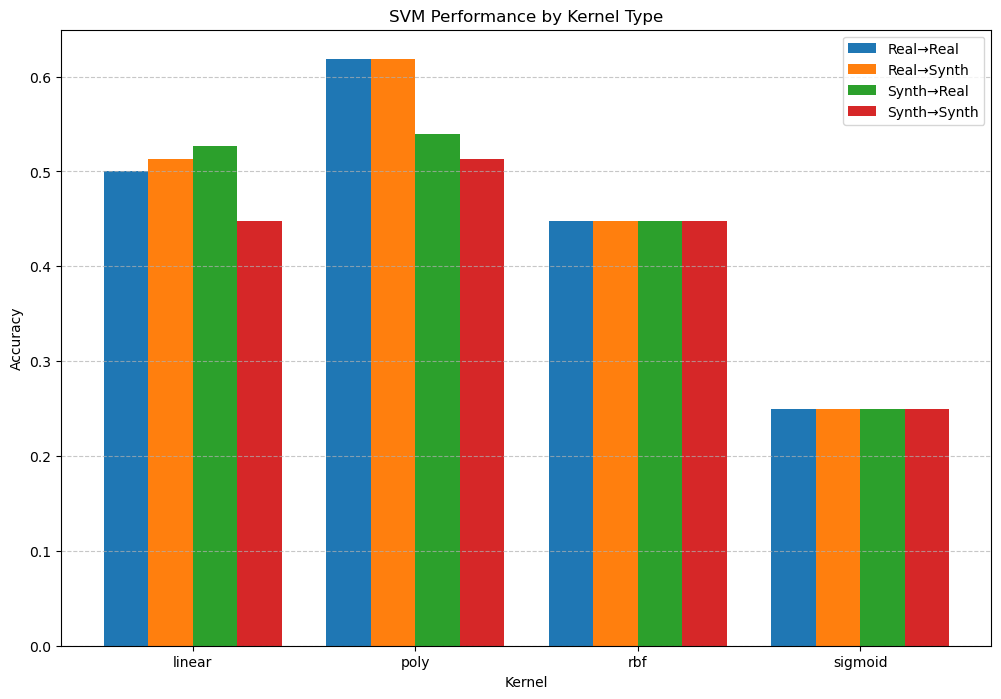

In [58]:

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
real_real_scores = []
real_synth_scores = []
synth_real_scores = []
synth_synth_scores = []

for kernel in kernels:
    # Real trained
    svm_real = SVC(kernel=kernel, C=1)
    svm_real.fit(X_train_real, y_train_real)
    
    # Synth trained
    svm_synth = SVC(kernel=kernel, C=1)
    svm_synth.fit(X_train_synth, y_train_synth)
    
    # Collect scores
    real_real_scores.append(svm_real.score(X_test_real, y_test_real))
    real_synth_scores.append(svm_real.score(X_test_synth, y_test_synth))
    synth_real_scores.append(svm_synth.score(X_test_real, y_test_real))
    synth_synth_scores.append(svm_synth.score(X_test_synth, y_test_synth))


plt.figure(figsize=(12, 8))
x = np.arange(len(kernels))
width = 0.2

plt.bar(x - width*1.5, real_real_scores, width, label='Real→Real')
plt.bar(x - width/2, real_synth_scores, width, label='Real→Synth')
plt.bar(x + width/2, synth_real_scores, width, label='Synth→Real')
plt.bar(x + width*1.5, synth_synth_scores, width, label='Synth→Synth')

plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.title('SVM Performance by Kernel Type')
plt.xticks(x, kernels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Random Forest


=== RF Real-trained on Real test ===
              precision    recall  f1-score   support

           0      0.556     0.526     0.541        19
           1      0.471     0.533     0.500        15
           2      0.571     0.842     0.681        19
           3      0.692     0.500     0.581        18
           4      0.000     0.000     0.000         5

    accuracy                          0.566        76
   macro avg      0.458     0.480     0.460        76
weighted avg      0.539     0.566     0.542        76


=== RF Real-trained on Synth test ===
              precision    recall  f1-score   support

           0      0.500     0.421     0.457        19
           1      0.421     0.533     0.471        15
           2      0.360     0.474     0.409        19
           3      0.625     0.556     0.588        18
           4      0.000     0.000     0.000         5

    accuracy                          0.461        76
   macro avg      0.381     0.397     0.385        76


C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packag

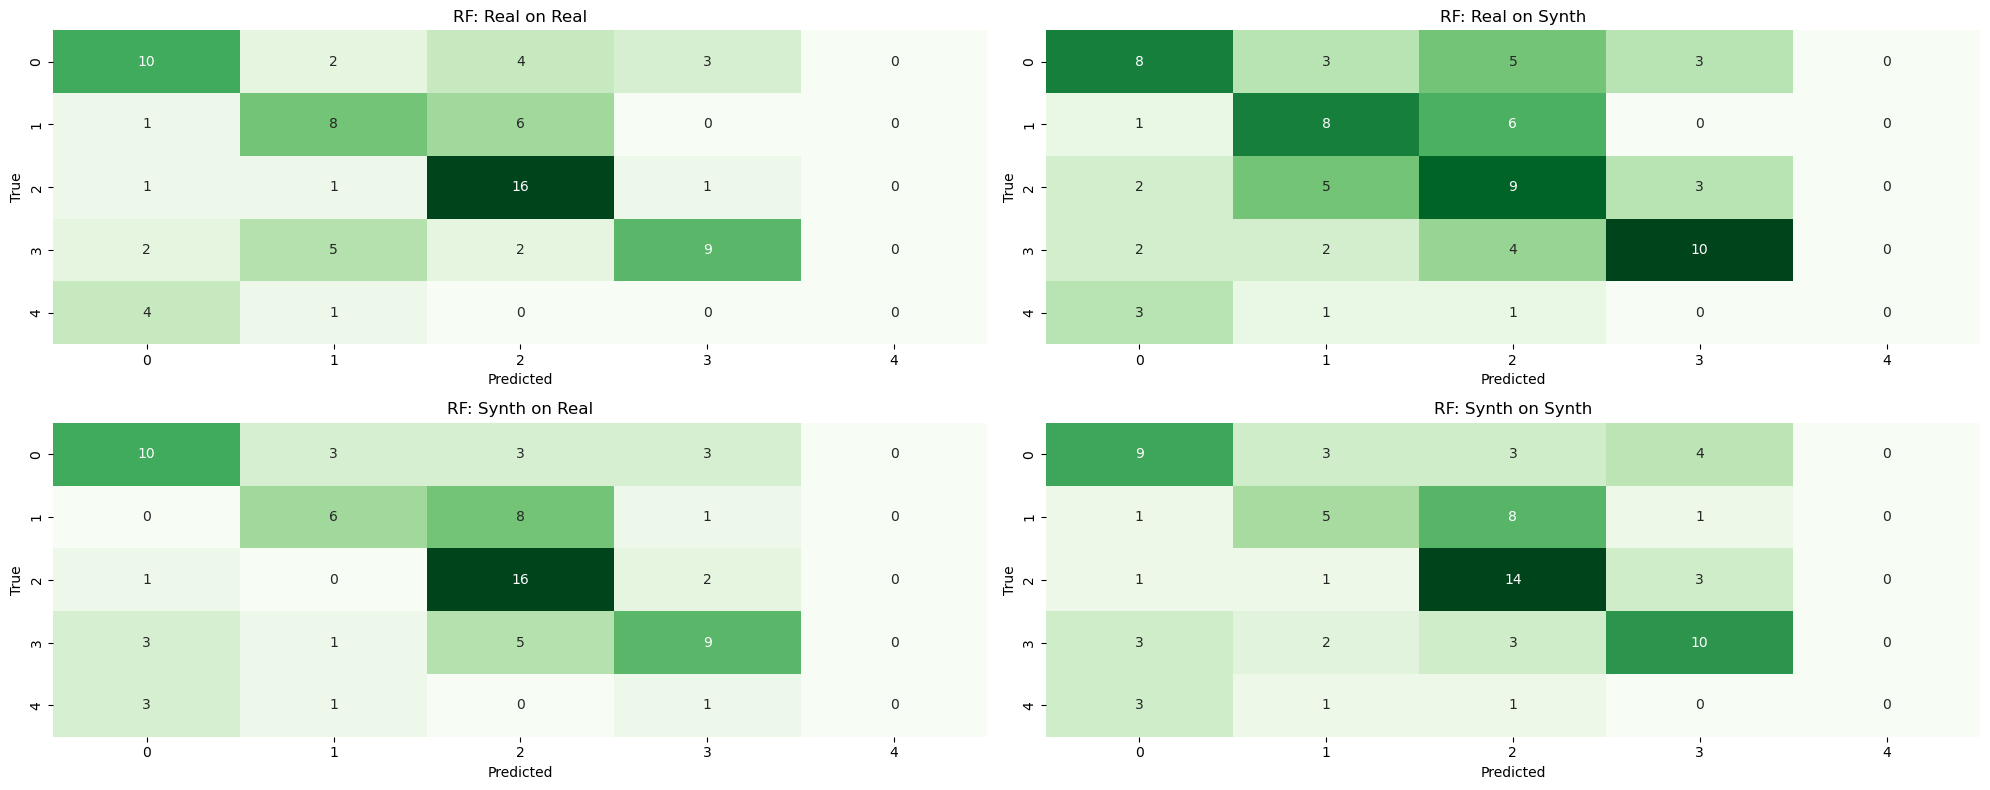

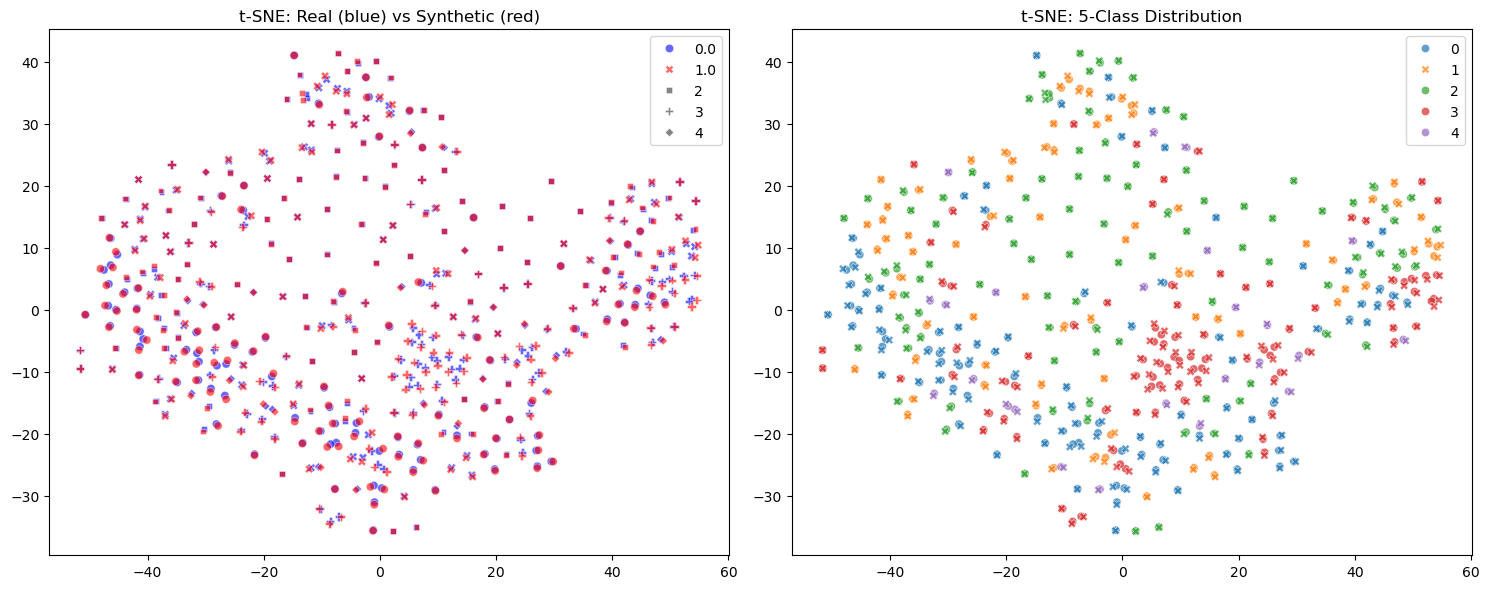

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

# -------------------------
# 1. Prepare Data
# -------------------------

# Real data
X_real = np.vstack([
    normalized_samples,
    normalized_samples_secondClass,
    normalized_samples_thirdClass,
    normalized_samples_fourthClass,
    normalized_samples_fifthClass
])
y_real = np.hstack([
    np.full(len(normalized_samples), 0),
    np.full(len(normalized_samples_secondClass), 1),
    np.full(len(normalized_samples_thirdClass), 2),
    np.full(len(normalized_samples_fourthClass), 3),
    np.full(len(normalized_samples_fifthClass), 4)
])

# Synthetic data
X_synth = np.vstack([
    generated_series,
    generated_series_class2,
    generated_series_class3,
    generated_series_class4,
    generated_series_class5
])
y_synth = np.hstack([
    np.full(len(generated_series), 0),
    np.full(len(generated_series_class2), 1),
    np.full(len(generated_series_class3), 2),
    np.full(len(generated_series_class4), 3),
    np.full(len(generated_series_class5), 4)
])

# -------------------------
# 2. Train/Test Split
# -------------------------

X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42, stratify=y_real
)
X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(
    X_synth, y_synth, test_size=0.2, random_state=42, stratify=y_synth
)

# -------------------------
# 3. Train Random Forests
# -------------------------

rf_real = RandomForestClassifier(n_estimators=100, random_state=42)
rf_real.fit(X_train_real, y_train_real)

rf_synth = RandomForestClassifier(n_estimators=100, random_state=42)
rf_synth.fit(X_train_synth, y_train_synth)

# -------------------------
# 4. Evaluation Function
# -------------------------

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=3))
    return confusion_matrix(y_test, y_pred)


cm_rf_real_real = evaluate_model("RF Real-trained on Real test", rf_real, X_test_real, y_test_real)
cm_rf_real_synth = evaluate_model("RF Real-trained on Synth test", rf_real, X_test_synth, y_test_synth)
cm_rf_synth_real = evaluate_model("RF Synth-trained on Real test", rf_synth, X_test_real, y_test_real)
cm_rf_synth_synth = evaluate_model("RF Synth-trained on Synth test", rf_synth, X_test_synth, y_test_synth)

# -------------------------
# 5. Confusion Matrices
# -------------------------

plt.figure(figsize=(20, 8))
titles = [
    "RF: Real on Real",
    "RF: Real on Synth",
    "RF: Synth on Real",
    "RF: Synth on Synth"
]
cms = [cm_rf_real_real, cm_rf_real_synth, cm_rf_synth_real, cm_rf_synth_synth]

for i, cm in enumerate(cms):
    plt.subplot(2, 2, i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
    plt.title(titles[i])
    plt.xlabel('Predicted')
    plt.ylabel('True')

plt.tight_layout()
plt.show()

# -------------------------
# 6. t-SNE Visualization
# -------------------------

X_combined = np.vstack([X_real, X_synth])
source_labels = np.hstack([np.zeros(len(X_real)), np.ones(len(X_synth))])  # 0 = real, 1 = synth
class_labels = np.hstack([y_real, y_synth])  # 0–4

X_embedded = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_combined)

plt.figure(figsize=(15, 6))


plt.subplot(1, 2, 1)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1],
                hue=source_labels, style=class_labels,
                palette=['blue', 'red'], alpha=0.6)
plt.title("t-SNE: Real (blue) vs Synthetic (red)")


plt.subplot(1, 2, 2)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1],
                hue=class_labels, style=source_labels,
                palette='tab10', alpha=0.7)
plt.title("t-SNE: 5-Class Distribution")

plt.tight_layout()
plt.show()


### RF - Feature importance analysis 

Spearman correlation between real and synthetic importance patterns: 0.355 (p=0.000)


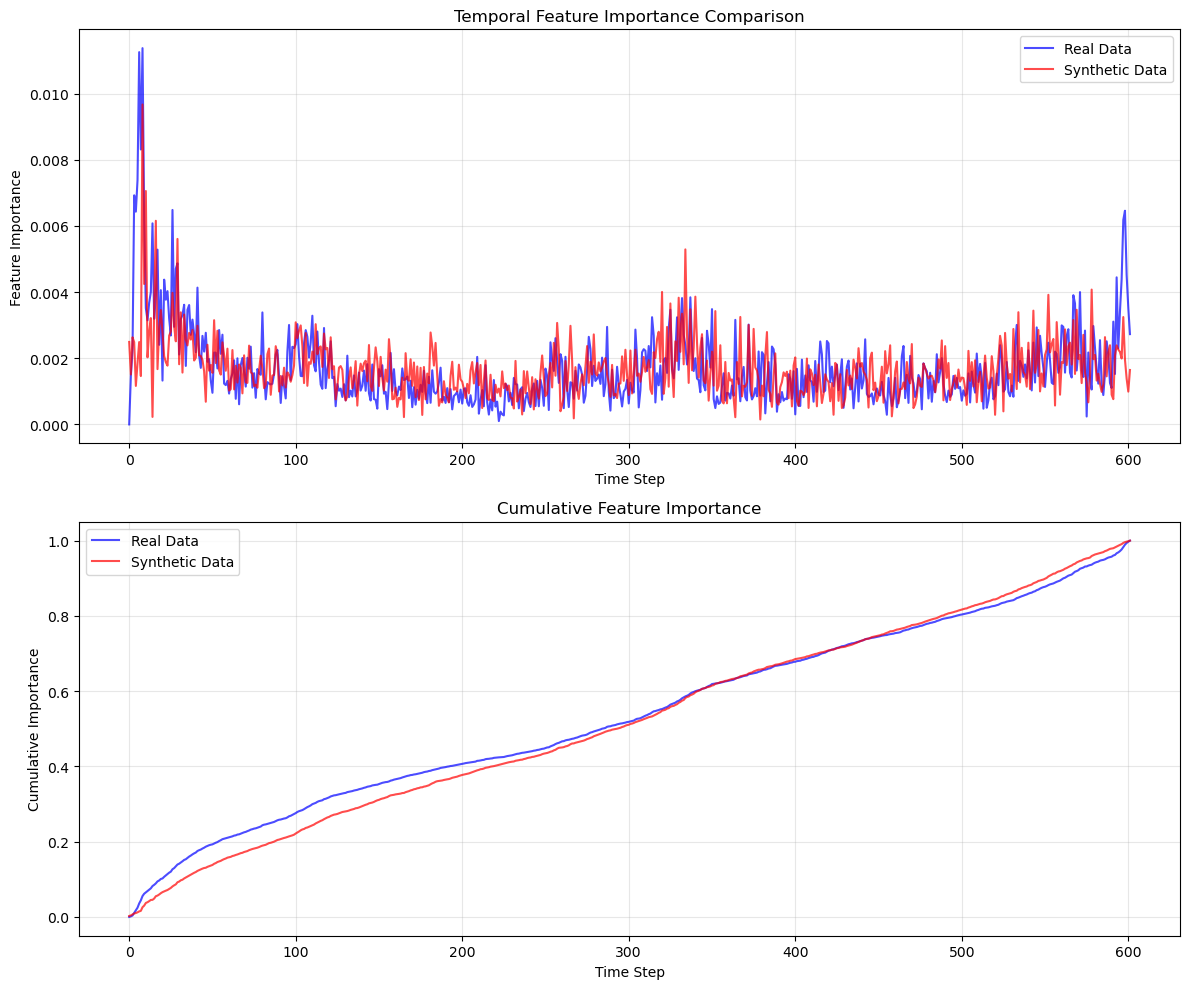

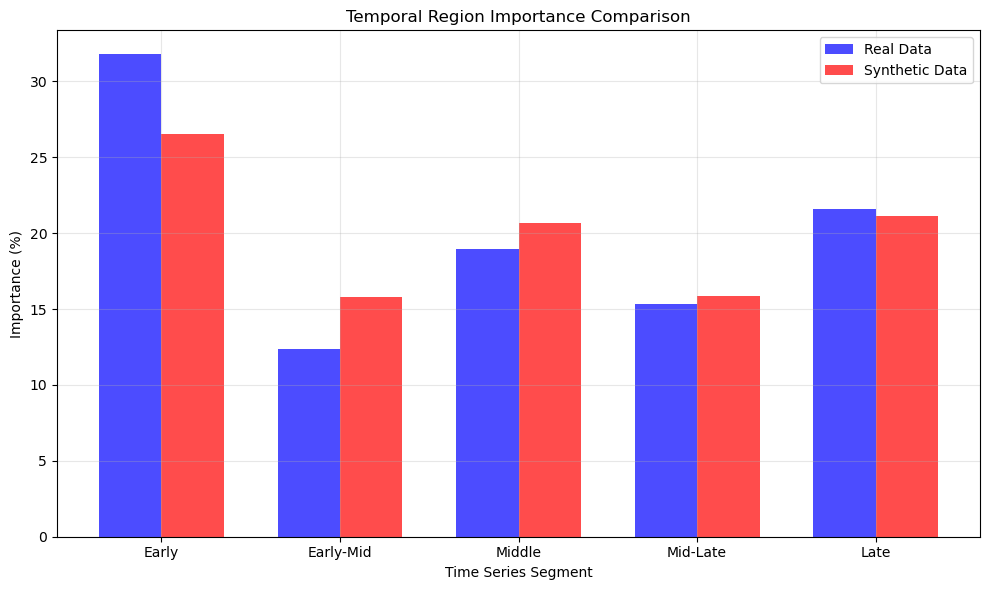

Top 10 most important time steps for real data:
1. Time step 8: 0.0114
2. Time step 6: 0.0113
3. Time step 7: 0.0083
4. Time step 5: 0.0074
5. Time step 3: 0.0069
6. Time step 26: 0.0065
7. Time step 598: 0.0065
8. Time step 4: 0.0064
9. Time step 9: 0.0062
10. Time step 597: 0.0062

Top 10 most important time steps for synthetic data:
1. Time step 8: 0.0097
2. Time step 10: 0.0071
3. Time step 16: 0.0062
4. Time step 29: 0.0056
5. Time step 334: 0.0053
6. Time step 9: 0.0042
7. Time step 578: 0.0041
8. Time step 320: 0.0040
9. Time step 26: 0.0040
10. Time step 552: 0.0039

Overlap between top important features: 3/10 (30.0%)
Overlapping time steps: [8, 9, 26]


In [60]:

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr


rf_real_importance = RandomForestClassifier(n_estimators=100, random_state=42)
rf_real_importance.fit(X_train_real, y_train_real)

rf_synth_importance = RandomForestClassifier(n_estimators=100, random_state=42)
rf_synth_importance.fit(X_train_synth, y_train_synth)


importances_real = rf_real_importance.feature_importances_
importances_synth = rf_synth_importance.feature_importances_


series_length = X_real.shape[1]


correlation, p_value = spearmanr(importances_real, importances_synth)
print(f"Spearman correlation between real and synthetic importance patterns: {correlation:.3f} (p={p_value:.3f})")


plt.figure(figsize=(12, 10))


plt.subplot(2, 1, 1)
plt.plot(range(series_length), importances_real, 'b-', label='Real Data', alpha=0.7)
plt.plot(range(series_length), importances_synth, 'r-', label='Synthetic Data', alpha=0.7)
plt.title('Temporal Feature Importance Comparison')
plt.xlabel('Time Step')
plt.ylabel('Feature Importance')
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(2, 1, 2)
plt.plot(range(series_length), np.cumsum(importances_real), 'b-', label='Real Data', alpha=0.7)
plt.plot(range(series_length), np.cumsum(importances_synth), 'r-', label='Synthetic Data', alpha=0.7)
plt.title('Cumulative Feature Importance')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Importance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


n_bins = 5
bin_size = series_length // n_bins
binned_importances_real = [importances_real[i*bin_size:(i+1)*bin_size].sum() for i in range(n_bins)]
binned_importances_synth = [importances_synth[i*bin_size:(i+1)*bin_size].sum() for i in range(n_bins)]


binned_importances_real = np.array(binned_importances_real) / sum(binned_importances_real) * 100
binned_importances_synth = np.array(binned_importances_synth) / sum(binned_importances_synth) * 100


plt.figure(figsize=(10, 6))
barWidth = 0.35
r1 = np.arange(n_bins)
r2 = [x + barWidth for x in r1]

plt.bar(r1, binned_importances_real, width=barWidth, label='Real Data', color='blue', alpha=0.7)
plt.bar(r2, binned_importances_synth, width=barWidth, label='Synthetic Data', color='red', alpha=0.7)

plt.xlabel('Time Series Segment')
plt.ylabel('Importance (%)')
plt.title('Temporal Region Importance Comparison')
plt.xticks([r + barWidth/2 for r in range(n_bins)], ['Early', 'Early-Mid', 'Middle', 'Mid-Late', 'Late'])
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


top_features_real = np.argsort(importances_real)[-10:][::-1]
top_features_synth = np.argsort(importances_synth)[-10:][::-1]

print("Top 10 most important time steps for real data:")
for i, idx in enumerate(top_features_real):
    print(f"{i+1}. Time step {idx}: {importances_real[idx]:.4f}")

print("\nTop 10 most important time steps for synthetic data:")
for i, idx in enumerate(top_features_synth):
    print(f"{i+1}. Time step {idx}: {importances_synth[idx]:.4f}")


overlap = set(top_features_real).intersection(set(top_features_synth))
print(f"\nOverlap between top important features: {len(overlap)}/{10} ({len(overlap)/10*100:.1f}%)")
print("Overlapping time steps:", sorted(list(overlap)))

## LSTM (XGBoost, LightGBM, CatBoost)

In [61]:
pip install xgboost lightgbm catboost

  Using cached xgboost-3.0.0-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
Using cached xgboost-3.0.0-py3-none-win_amd64.whl (150.0 MB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
    --------------------------------------- 2.1/102.4 MB 19.5 MB/s eta 0:00:06
   - -------------------------------------- 4.2/102.4 MB 12.6 MB/s eta 0:00:08
   -- ------------------------------------- 6.3/102.4 MB 11.0 MB/s eta 0:00:09
   ---- ----------------------------------- 10.5/102.4 MB 13.1 MB/s eta 0:00:08
   ---- ----------------------------------- 12.6/102.4 MB 12.3 MB/s eta 0:00:08
   ----- ---------------------------------- 14.7/102.4 MB 12.8 MB/s eta 0:00:07
   ------ --------------------------------- 17.8/102.4 MB 12.8 MB/s eta 0:00:07
   ------ --------------------------------- 17

### XGBoost

C:\Users\mrnew\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:21:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\mrnew\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:21:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGB Real-trained on Real test ===
              precision    recall  f1-score   support

           0      0.571     0.421     0.485        19
           1      0.440     0.733     0.550        15
           2      0.700     0.737     0.718        19
           3      0.588     0.556     0.571        18
           4      0.000     0.000     0.000         5

    accuracy                          0.566        76
   macro avg      0.460     0.489     0.465        76
weighted avg      0.544     0.566     0.545        76


=== XGB Real-trained on Synth test ===
              precision    recall  f1-score   support

           0      0.636     0.368     0.467        19
           1      0.286     0.400     0.333        15
           2      0.318     0.368     0.341        19
           3      0.450     0.500     0.474        18
           4      0.500     0.200     0.286         5

    accuracy                          0.395        76
   macro avg      0.438     0.367     0.380        7

C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packag

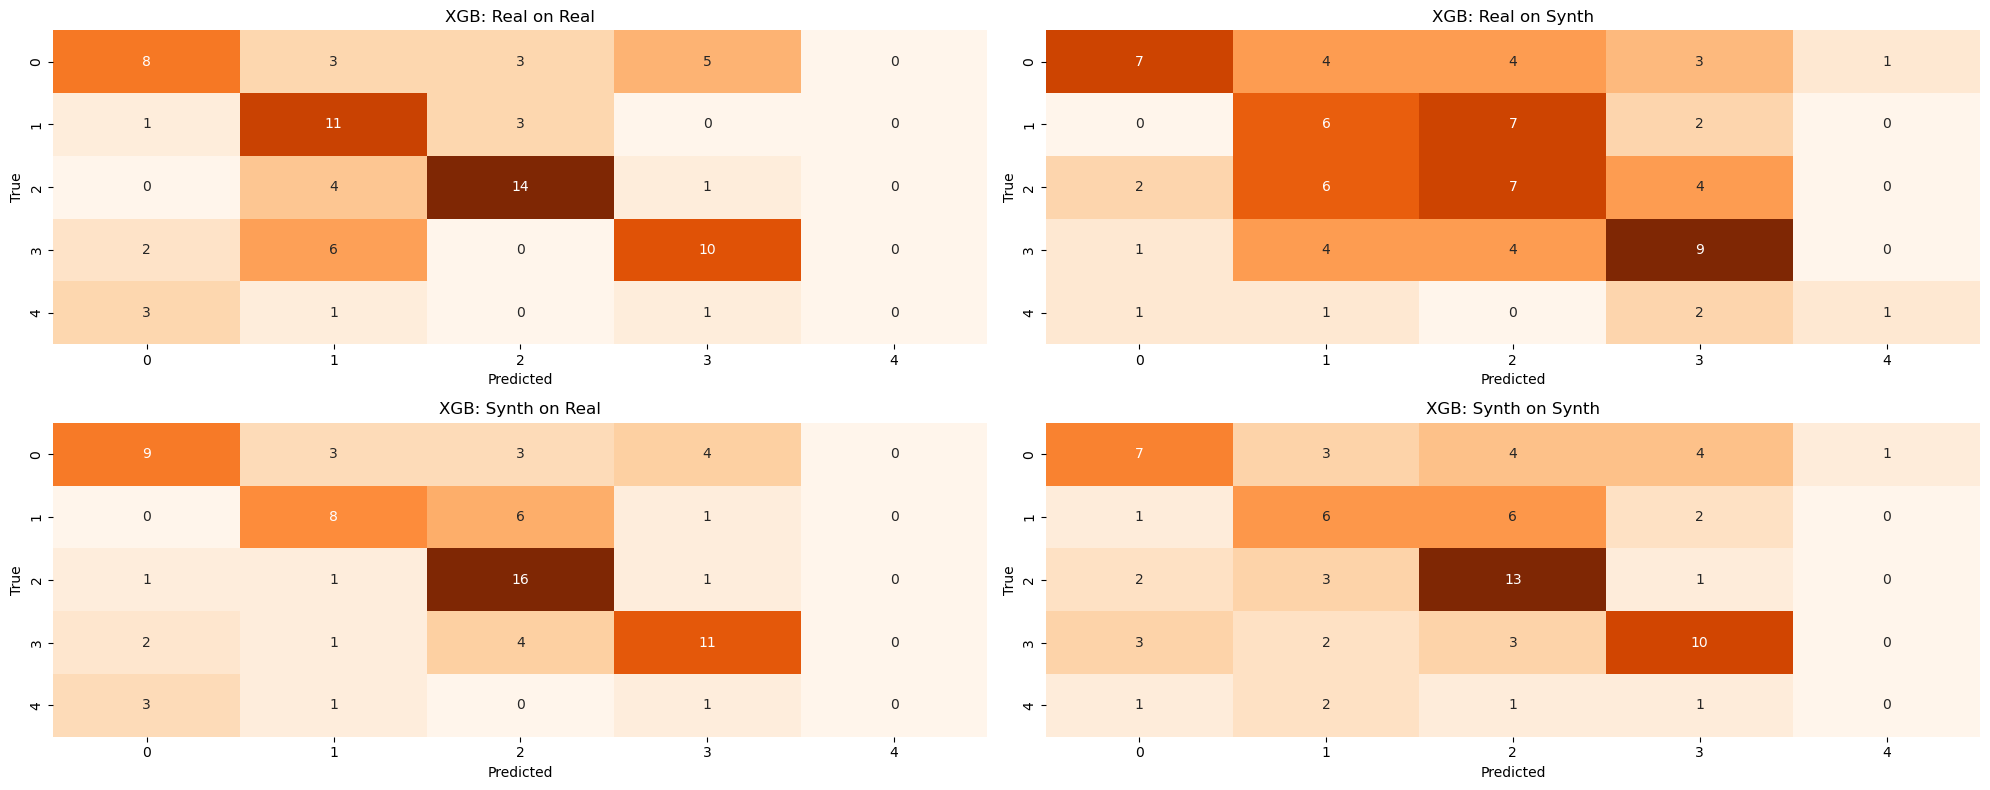

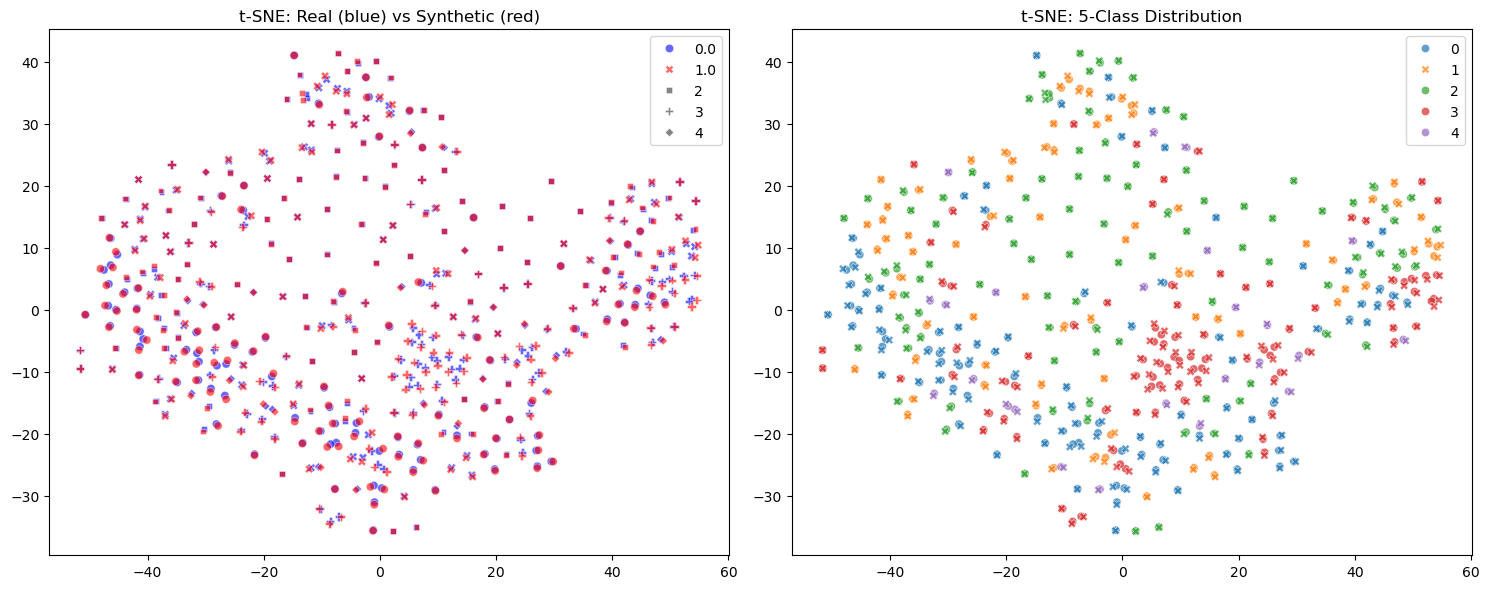

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from xgboost import XGBClassifier

# -------------------------
# 1. Prepare Data
# -------------------------

# Real data
X_real = np.vstack([
    normalized_samples,
    normalized_samples_secondClass,
    normalized_samples_thirdClass,
    normalized_samples_fourthClass,
    normalized_samples_fifthClass
])
y_real = np.hstack([
    np.full(len(normalized_samples), 0),
    np.full(len(normalized_samples_secondClass), 1),
    np.full(len(normalized_samples_thirdClass), 2),
    np.full(len(normalized_samples_fourthClass), 3),
    np.full(len(normalized_samples_fifthClass), 4)
])

# Synthetic data
X_synth = np.vstack([
    generated_series,
    generated_series_class2,
    generated_series_class3,
    generated_series_class4,
    generated_series_class5
])
y_synth = np.hstack([
    np.full(len(generated_series), 0),
    np.full(len(generated_series_class2), 1),
    np.full(len(generated_series_class3), 2),
    np.full(len(generated_series_class4), 3),
    np.full(len(generated_series_class5), 4)
])

# -------------------------
# 2. Train/Test Split
# -------------------------

X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42, stratify=y_real
)
X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(
    X_synth, y_synth, test_size=0.2, random_state=42, stratify=y_synth
)

# -------------------------
# 3. Train XGBoost Models
# -------------------------

xgb_real = XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgb_real.fit(X_train_real, y_train_real)

xgb_synth = XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgb_synth.fit(X_train_synth, y_train_synth)

# -------------------------
# 4. Evaluation Function
# -------------------------

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=3))
    return confusion_matrix(y_test, y_pred)


cm_xgb_real_real = evaluate_model("XGB Real-trained on Real test", xgb_real, X_test_real, y_test_real)
cm_xgb_real_synth = evaluate_model("XGB Real-trained on Synth test", xgb_real, X_test_synth, y_test_synth)
cm_xgb_synth_real = evaluate_model("XGB Synth-trained on Real test", xgb_synth, X_test_real, y_test_real)
cm_xgb_synth_synth = evaluate_model("XGB Synth-trained on Synth test", xgb_synth, X_test_synth, y_test_synth)

# -------------------------
# 5. Confusion Matrices
# -------------------------

plt.figure(figsize=(20, 8))
titles = [
    "XGB: Real on Real",
    "XGB: Real on Synth",
    "XGB: Synth on Real",
    "XGB: Synth on Synth"
]
cms = [cm_xgb_real_real, cm_xgb_real_synth, cm_xgb_synth_real, cm_xgb_synth_synth]

for i, cm in enumerate(cms):
    plt.subplot(2, 2, i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False)
    plt.title(titles[i])
    plt.xlabel('Predicted')
    plt.ylabel('True')

plt.tight_layout()
plt.show()

# -------------------------
# 6. t-SNE Visualization
# -------------------------

X_combined = np.vstack([X_real, X_synth])
source_labels = np.hstack([np.zeros(len(X_real)), np.ones(len(X_synth))])  # 0 = real, 1 = synth
class_labels = np.hstack([y_real, y_synth])  # 0–4

X_embedded = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_combined)

plt.figure(figsize=(15, 6))


plt.subplot(1, 2, 1)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1],
                hue=source_labels, style=class_labels,
                palette=['blue', 'red'], alpha=0.6)
plt.title("t-SNE: Real (blue) vs Synthetic (red)")


plt.subplot(1, 2, 2)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1],
                hue=class_labels, style=source_labels,
                palette='tab10', alpha=0.7)
plt.title("t-SNE: 5-Class Distribution")

plt.tight_layout()
plt.show()


In [64]:
pip install shap

  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
   ---------------------------------------- 0.0/545.2 kB ? eta -:--:--
   ---------------------------------------- 545.2/545.2 kB 2.6 MB/s eta 0:00:00
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Note: you may need to restart the kernel to use updated packages.


Generating SHAP explanations...


<Figure size 800x950 with 0 Axes>

<Figure size 1150x660 with 0 Axes>

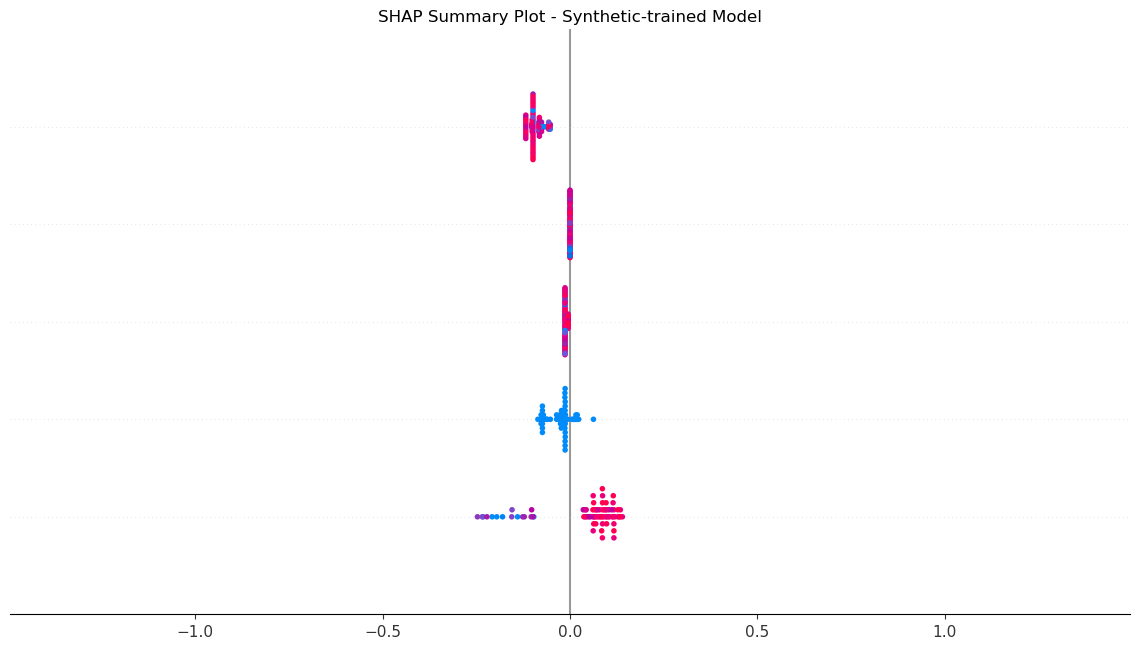


SHAP Value Correlation Analysis (Real vs Synthetic):
Class 0 SHAP correlation: 0.1478
Class 1 SHAP correlation: 0.0783
Class 2 SHAP correlation: 0.1584
Class 3 SHAP correlation: 0.1382
Class 4 SHAP correlation: 0.0857


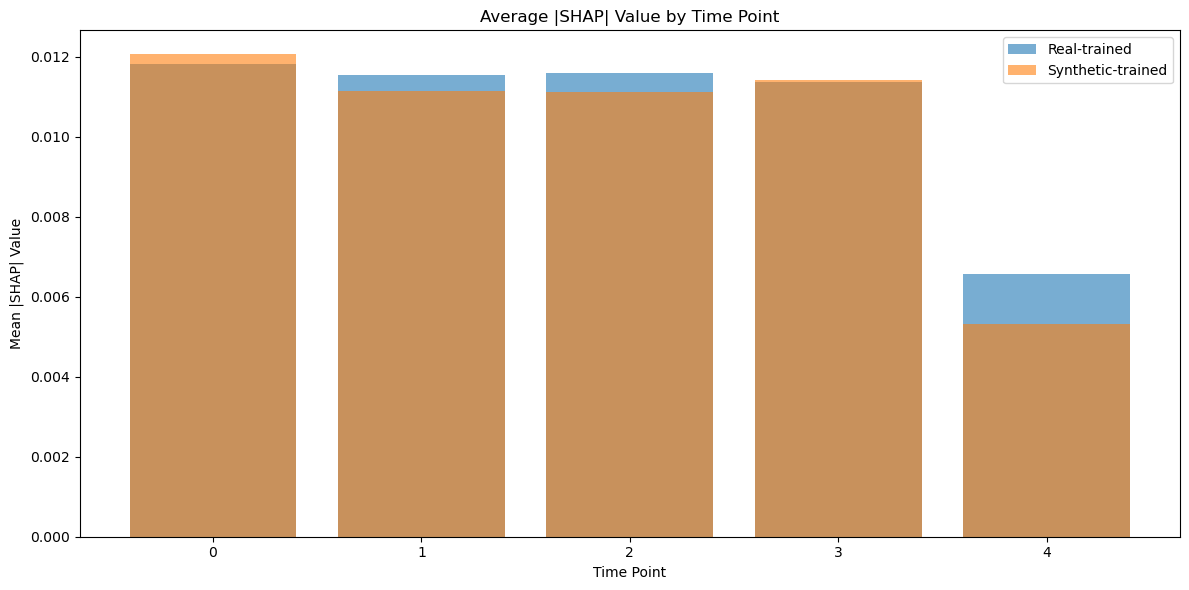


Time-point importance correlation: 0.9941


In [66]:
import shap
import matplotlib.pyplot as plt


# -------------------------
# 7. SHAP Analysis
# -------------------------


print("Generating SHAP explanations...")
explainer_real = shap.TreeExplainer(xgb_real)
explainer_synth = shap.TreeExplainer(xgb_synth)

n_samples = min(100, len(X_test_real))  
sample_indices = np.random.choice(len(X_test_real), n_samples, replace=False)
X_shap_sample = X_test_real[sample_indices]
y_shap_sample = y_test_real[sample_indices]

shap_values_real = explainer_real.shap_values(X_shap_sample)
shap_values_synth = explainer_synth.shap_values(X_shap_sample)


feature_names = [f"t{i}" for i in range(X_real.shape[1])]


plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
shap.summary_plot(shap_values_real, X_shap_sample, feature_names=feature_names, 
                  plot_type="bar", show=False, class_names=[f"Class {i}" for i in range(5)])
plt.title("SHAP Feature Importance - Real-trained Model")

plt.subplot(2, 2, 2)
shap.summary_plot(shap_values_synth, X_shap_sample, feature_names=feature_names, 
                  plot_type="bar", show=False, class_names=[f"Class {i}" for i in range(5)])
plt.title("SHAP Feature Importance - Synthetic-trained Model")

plt.subplot(2, 2, 3)
shap.summary_plot(shap_values_real, X_shap_sample, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot - Real-trained Model")

plt.subplot(2, 2, 4)
shap.summary_plot(shap_values_synth, X_shap_sample, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot - Synthetic-trained Model")

plt.tight_layout()
plt.savefig('shap_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate SHAP value correlation for each class
print("\nSHAP Value Correlation Analysis (Real vs Synthetic):")
for class_idx in range(5):
    # Flatten values for this class
    real_shap_flat = np.array(shap_values_real[class_idx]).flatten()
    synth_shap_flat = np.array(shap_values_synth[class_idx]).flatten()
    
    # Calculate correlation
    corr = np.corrcoef(real_shap_flat, synth_shap_flat)[0, 1]
    print(f"Class {class_idx} SHAP correlation: {corr:.4f}")

# Analyze feature importance correlation by time point
real_importance = np.abs(np.array(shap_values_real)).mean(axis=0).mean(axis=0)
synth_importance = np.abs(np.array(shap_values_synth)).mean(axis=0).mean(axis=0)

plt.figure(figsize=(12, 6))
plt.bar(range(len(real_importance)), real_importance, alpha=0.6, label='Real-trained')
plt.bar(range(len(synth_importance)), synth_importance, alpha=0.6, label='Synthetic-trained')
plt.title('Average |SHAP| Value by Time Point')
plt.xlabel('Time Point')
plt.ylabel('Mean |SHAP| Value')
plt.legend()
plt.tight_layout()
plt.savefig('shap_importance_by_timepoint.png', dpi=300)
plt.show()

# Calculate overall correlation between importance profiles
time_corr = np.corrcoef(real_importance, synth_importance)[0, 1]
print(f"\nTime-point importance correlation: {time_corr:.4f}")

### CatBoost


=== CatBoost Real-trained on Real test ===
              precision    recall  f1-score   support

           0      0.750     0.474     0.581        19
           1      0.579     0.733     0.647        15
           2      0.615     0.842     0.711        19
           3      0.667     0.667     0.667        18
           4      1.000     0.200     0.333         5

    accuracy                          0.645        76
   macro avg      0.722     0.583     0.588        76
weighted avg      0.679     0.645     0.630        76


=== CatBoost Real-trained on Synth test ===
              precision    recall  f1-score   support

           0      0.667     0.421     0.516        19
           1      0.364     0.533     0.432        15
           2      0.500     0.632     0.558        19
           3      0.611     0.611     0.611        18
           4      0.000     0.000     0.000         5

    accuracy                          0.513        76
   macro avg      0.428     0.439     0.42

C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packag


=== CatBoost Synth-trained on Real test ===
              precision    recall  f1-score   support

           0      0.625     0.526     0.571        19
           1      0.643     0.600     0.621        15
           2      0.571     0.842     0.681        19
           3      0.611     0.611     0.611        18
           4      0.000     0.000     0.000         5

    accuracy                          0.605        76
   macro avg      0.490     0.516     0.497        76
weighted avg      0.571     0.605     0.580        76


=== CatBoost Synth-trained on Synth test ===
              precision    recall  f1-score   support

           0      0.647     0.579     0.611        19
           1      0.500     0.533     0.516        15
           2      0.481     0.684     0.565        19
           3      0.562     0.500     0.529        18
           4      0.000     0.000     0.000         5

    accuracy                          0.539        76
   macro avg      0.438     0.459     0.

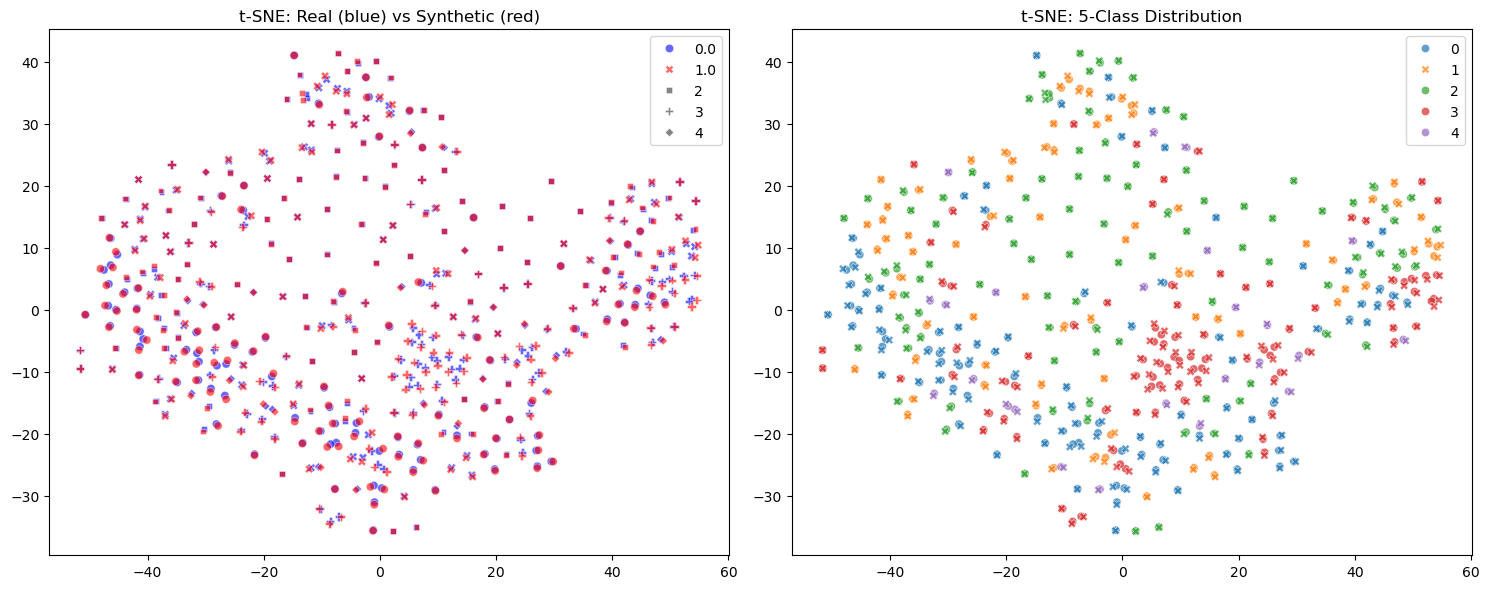

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from catboost import CatBoostClassifier

# -------------------------
# 1. Prepare Data
# -------------------------

# Real data
X_real = np.vstack([
    normalized_samples,
    normalized_samples_secondClass,
    normalized_samples_thirdClass,
    normalized_samples_fourthClass,
    normalized_samples_fifthClass
])
y_real = np.hstack([
    np.full(len(normalized_samples), 0),
    np.full(len(normalized_samples_secondClass), 1),
    np.full(len(normalized_samples_thirdClass), 2),
    np.full(len(normalized_samples_fourthClass), 3),
    np.full(len(normalized_samples_fifthClass), 4)
])

# Synthetic data
X_synth = np.vstack([
    generated_series,
    generated_series_class2,
    generated_series_class3,
    generated_series_class4,
    generated_series_class5
])
y_synth = np.hstack([
    np.full(len(generated_series), 0),
    np.full(len(generated_series_class2), 1),
    np.full(len(generated_series_class3), 2),
    np.full(len(generated_series_class4), 3),
    np.full(len(generated_series_class5), 4)
])

# -------------------------
# 2. Train/Test Split
# -------------------------

X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42, stratify=y_real
)
X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(
    X_synth, y_synth, test_size=0.2, random_state=42, stratify=y_synth
)

# -------------------------
# 3. Train CatBoost Models
# -------------------------

cb_real = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    verbose=0,
    random_seed=42
)
cb_real.fit(X_train_real, y_train_real)

cb_synth = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    verbose=0,
    random_seed=42
)
cb_synth.fit(X_train_synth, y_train_synth)

# -------------------------
# 4. Evaluation Function
# -------------------------

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test).flatten()
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=3))
    return confusion_matrix(y_test, y_pred)


cm_cb_real_real = evaluate_model("CatBoost Real-trained on Real test", cb_real, X_test_real, y_test_real)
cm_cb_real_synth = evaluate_model("CatBoost Real-trained on Synth test", cb_real, X_test_synth, y_test_synth)
cm_cb_synth_real = evaluate_model("CatBoost Synth-trained on Real test", cb_synth, X_test_real, y_test_real)
cm_cb_synth_synth = evaluate_model("CatBoost Synth-trained on Synth test", cb_synth, X_test_synth, y_test_synth)

# -------------------------
# 5. Confusion Matrices
# -------------------------

plt.figure(figsize=(20, 8))
titles = [
    "CatBoost: Real on Real",
    "CatBoost: Real on Synth",
    "CatBoost: Synth on Real",
    "CatBoost: Synth on Synth"
]
cms = [cm_cb_real_real, cm_cb_real_synth, cm_cb_synth_real, cm_cb_synth_synth]

for i, cm in enumerate(cms):
    plt.subplot(2, 2, i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
    plt.title(titles[i])
    plt.xlabel('Predicted')
    plt.ylabel('True')

plt.tight_layout()
plt.show()

# -------------------------
# 6. t-SNE Visualization
# -------------------------

X_combined = np.vstack([X_real, X_synth])
source_labels = np.hstack([np.zeros(len(X_real)), np.ones(len(X_synth))])  # 0 = real, 1 = synth
class_labels = np.hstack([y_real, y_synth])  # 0–4

X_embedded = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_combined)

plt.figure(figsize=(15, 6))


plt.subplot(1, 2, 1)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1],
                hue=source_labels, style=class_labels,
                palette=['blue', 'red'], alpha=0.6)
plt.title("t-SNE: Real (blue) vs Synthetic (red)")


plt.subplot(1, 2, 2)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1],
                hue=class_labels, style=source_labels,
                palette='tab10', alpha=0.7)
plt.title("t-SNE: 5-Class Distribution")

plt.tight_layout()
plt.show()


### LightGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60653
[LightGBM] [Info] Number of data points in the train set: 301, number of used features: 601
[LightGBM] [Info] Start training from score -1.376377
[LightGBM] [Info] Start training from score -1.646667
[LightGBM] [Info] Start training from score -1.363305
[LightGBM] [Info] Start training from score -1.444430
[LightGBM] [Info] Start training from score -2.762671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


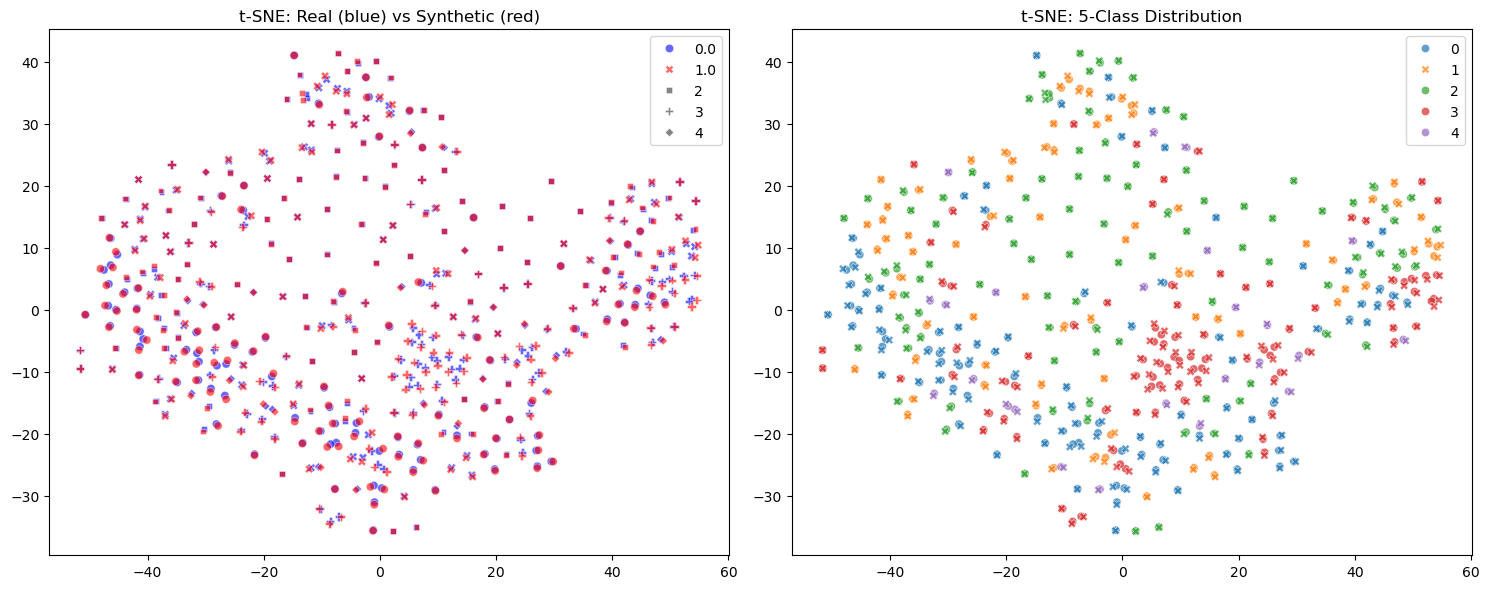

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from lightgbm import LGBMClassifier

# -------------------------
# 1. Prepare Data
# -------------------------

# Real data
X_real = np.vstack([
    normalized_samples,
    normalized_samples_secondClass,
    normalized_samples_thirdClass,
    normalized_samples_fourthClass,
    normalized_samples_fifthClass
])
y_real = np.hstack([
    np.full(len(normalized_samples), 0),
    np.full(len(normalized_samples_secondClass), 1),
    np.full(len(normalized_samples_thirdClass), 2),
    np.full(len(normalized_samples_fourthClass), 3),
    np.full(len(normalized_samples_fifthClass), 4)
])

# Synthetic data
X_synth = np.vstack([
    generated_series,
    generated_series_class2,
    generated_series_class3,
    generated_series_class4,
    generated_series_class5
])
y_synth = np.hstack([
    np.full(len(generated_series), 0),
    np.full(len(generated_series_class2), 1),
    np.full(len(generated_series_class3), 2),
    np.full(len(generated_series_class4), 3),
    np.full(len(generated_series_class5), 4)
])

# -------------------------
# 2. Train/Test Split
# -------------------------

X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42, stratify=y_real
)
X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(
    X_synth, y_synth, test_size=0.2, random_state=42, stratify=y_synth
)

# -------------------------
# 3. Train LightGBM Models
# -------------------------

lgbm_real = LGBMClassifier(
    objective='multiclass',
    num_class=5,
    random_state=42
)
lgbm_real.fit(X_train_real, y_train_real)

lgbm_synth = LGBMClassifier(
    objective='multiclass',
    num_class=5,
    random_state=42
)
lgbm_synth.fit(X_train_synth, y_train_synth)

# -------------------------
# 4. Evaluation Function
# -------------------------

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=3))
    return confusion_matrix(y_test, y_pred)


cm_lgbm_real_real = evaluate_model("LGBM Real-trained on Real test", lgbm_real, X_test_real, y_test_real)
cm_lgbm_real_synth = evaluate_model("LGBM Real-trained on Synth test", lgbm_real, X_test_synth, y_test_synth)
cm_lgbm_synth_real = evaluate_model("LGBM Synth-trained on Real test", lgbm_synth, X_test_real, y_test_real)
cm_lgbm_synth_synth = evaluate_model("LGBM Synth-trained on Synth test", lgbm_synth, X_test_synth, y_test_synth)

# -------------------------
# 5. Confusion Matrices
# -------------------------

plt.figure(figsize=(20, 8))
titles = [
    "LGBM: Real on Real",
    "LGBM: Real on Synth",
    "LGBM: Synth on Real",
    "LGBM: Synth on Synth"
]
cms = [cm_lgbm_real_real, cm_lgbm_real_synth, cm_lgbm_synth_real, cm_lgbm_synth_synth]

for i, cm in enumerate(cms):
    plt.subplot(2, 2, i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
    plt.title(titles[i])
    plt.xlabel('Predicted')
    plt.ylabel('True')

plt.tight_layout()
plt.show()

# -------------------------
# 6. t-SNE Visualization
# -------------------------

X_combined = np.vstack([X_real, X_synth])
source_labels = np.hstack([np.zeros(len(X_real)), np.ones(len(X_synth))])  # 0 = real, 1 = synth
class_labels = np.hstack([y_real, y_synth])  # 0–4

X_embedded = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_combined)

plt.figure(figsize=(15, 6))


plt.subplot(1, 2, 1)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1],
                hue=source_labels, style=class_labels,
                palette=['blue', 'red'], alpha=0.6)
plt.title("t-SNE: Real (blue) vs Synthetic (red)")


plt.subplot(1, 2, 2)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1],
                hue=class_labels, style=source_labels,
                palette='tab10', alpha=0.7)
plt.title("t-SNE: 5-Class Distribution")

plt.tight_layout()
plt.show()


## k-NN

In [89]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np

# Prepare real data and labels
real_data = np.concatenate([
    normalized_samples,
    normalized_samples_secondClass,
    normalized_samples_thirdClass,
    normalized_samples_fourthClass,
    normalized_samples_fifthClass
])
real_labels = np.concatenate([
    np.zeros(len(normalized_samples)),
    np.ones(len(normalized_samples_secondClass)),
    np.full(len(normalized_samples_thirdClass), 2),
    np.full(len(normalized_samples_fourthClass), 3),
    np.full(len(normalized_samples_fifthClass), 4)
])

# Prepare synthetic data and labels
synth_data = np.concatenate([
    generated_series,
    generated_series_class2,
    generated_series_class3,
    generated_series_class4,
    generated_series_class5
])
synth_labels = np.concatenate([
    np.zeros(len(generated_series)),
    np.ones(len(generated_series_class2)),
    np.full(len(generated_series_class3), 2),
    np.full(len(generated_series_class4), 3),
    np.full(len(generated_series_class5), 4)
])

# Function to evaluate a trained k-NN model
def evaluate_knn(train_data, train_labels, test_data, test_labels, description=""):
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(train_data, train_labels)
    preds = clf.predict(test_data)
    print(f"\n=== k-NN {description} ===")
    print(classification_report(test_labels, preds, digits=3))
    
    accuracy = accuracy_score(test_labels, preds)
    precision = precision_score(test_labels, preds, average='macro')
    recall = recall_score(test_labels, preds, average='macro')
    f1 = f1_score(test_labels, preds, average='macro')
    
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Macro Precision: {precision:.3f}")
    print(f"Macro Recall:    {recall:.3f}")
    print(f"Macro F1-Score:  {f1:.3f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Create consistent train/test splits for both domains
# For Real data
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    real_data, real_labels, test_size=0.2, random_state=42, stratify=real_labels
)

# For Synthetic data
X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(
    synth_data, synth_labels, test_size=0.2, random_state=42, stratify=synth_labels
)

# 1. Real → Real
real_real_metrics = evaluate_knn(X_train_real, y_train_real, X_test_real, y_test_real, 
                                "Real-trained on Real test")

# 2. Synthetic → Synthetic
synth_synth_metrics = evaluate_knn(X_train_synth, y_train_synth, X_test_synth, y_test_synth, 
                                   "Synthetic-trained on Synthetic test")

# 3. Real → Synthetic (now with proper train/test split)
real_synth_metrics = evaluate_knn(X_train_real, y_train_real, X_test_synth, y_test_synth, 
                                 "Real-trained on Synthetic test")

# 4. Synthetic → Real (now with proper train/test split)
synth_real_metrics = evaluate_knn(X_train_synth, y_train_synth, X_test_real, y_test_real, 
                                 "Synthetic-trained on Real test")

# Create a summary table
print("\n===== SUMMARY =====")
print("Train → Test\tAccuracy\tPrecision\tRecall\t\tF1-Score")
print("-" * 75)
print(f"Real → Real\t{real_real_metrics['accuracy']:.3f}\t\t{real_real_metrics['precision']:.3f}\t\t{real_real_metrics['recall']:.3f}\t\t{real_real_metrics['f1']:.3f}")
print(f"Real → Synthetic\t{real_synth_metrics['accuracy']:.3f}\t\t{real_synth_metrics['precision']:.3f}\t\t{real_synth_metrics['recall']:.3f}\t\t{real_synth_metrics['f1']:.3f}")
print(f"Synthetic → Real\t{synth_real_metrics['accuracy']:.3f}\t\t{synth_real_metrics['precision']:.3f}\t\t{synth_real_metrics['recall']:.3f}\t\t{synth_real_metrics['f1']:.3f}")
print(f"Synthetic → Synthetic\t{synth_synth_metrics['accuracy']:.3f}\t\t{synth_synth_metrics['precision']:.3f}\t\t{synth_synth_metrics['recall']:.3f}\t\t{synth_synth_metrics['f1']:.3f}")


=== k-NN Real-trained on Real test ===
              precision    recall  f1-score   support

         0.0      0.423     0.579     0.489        19
         1.0      0.421     0.533     0.471        15
         2.0      0.429     0.316     0.364        19
         3.0      0.625     0.556     0.588        18
         4.0      1.000     0.200     0.333         5

    accuracy                          0.474        76
   macro avg      0.580     0.437     0.449        76
weighted avg      0.510     0.474     0.467        76

Accuracy: 0.474
Macro Precision: 0.580
Macro Recall:    0.437
Macro F1-Score:  0.449

=== k-NN Synthetic-trained on Synthetic test ===
              precision    recall  f1-score   support

         0.0      0.423     0.579     0.489        19
         1.0      0.421     0.533     0.471        15
         2.0      0.400     0.316     0.353        19
         3.0      0.600     0.500     0.545        18
         4.0      1.000     0.200     0.333         5

    accura

### k-NN - DTW based on KNN

Real data shape:    (377, 602)
Real labels shape:  (377,)
Synth data shape:   (377, 602)
Synth labels shape: (377,)


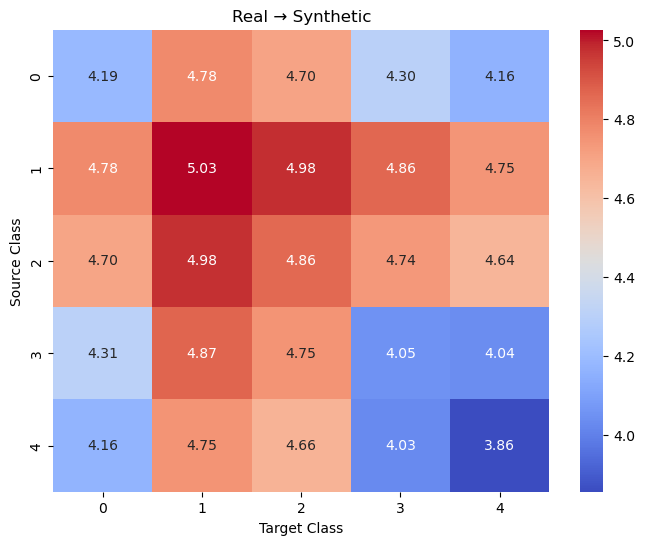

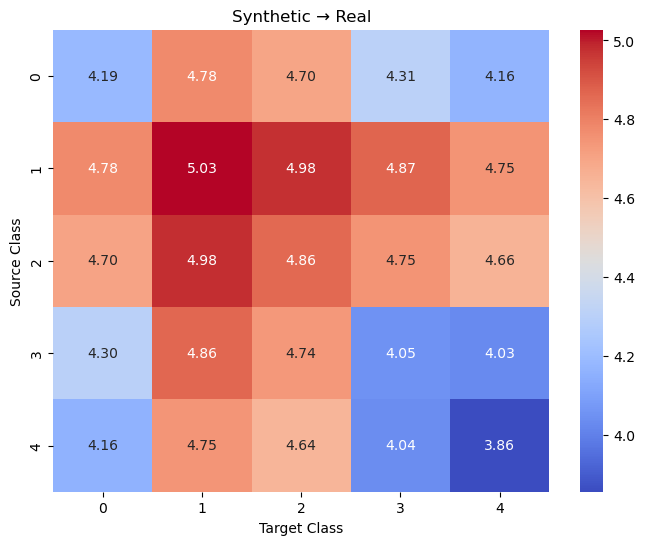

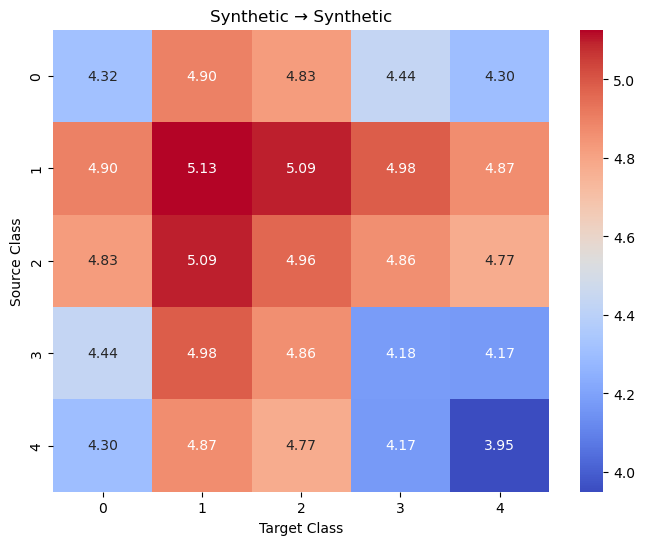

In [86]:
from scipy.spatial.distance import cdist
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def print_shapes():
    print("Real data shape:   ", real_data.shape)
    print("Real labels shape: ", real_labels.shape)
    print("Synth data shape:  ", synth_data.shape)
    print("Synth labels shape:", synth_labels.shape)


def prepare_labeled_data():
    real_parts = [
        normalized_samples,
        normalized_samples_secondClass,
        normalized_samples_thirdClass,
        normalized_samples_fourthClass,
        normalized_samples_fifthClass
    ]
    real_labels_parts = [
        np.zeros(len(normalized_samples)),
        np.ones(len(normalized_samples_secondClass)),
        np.full(len(normalized_samples_thirdClass), 2),
        np.full(len(normalized_samples_fourthClass), 3),
        np.full(len(normalized_samples_fifthClass), 4)
    ]

    synth_parts = [
        generated_series,
        generated_series_class2,
        generated_series_class3,
        generated_series_class4,
        generated_series_class5
    ]
    synth_labels_parts = [
        np.zeros(len(generated_series)),
        np.ones(len(generated_series_class2)),
        np.full(len(generated_series_class3), 2),
        np.full(len(generated_series_class4), 3),
        np.full(len(generated_series_class5), 4)
    ]

    real_data = np.concatenate(real_parts, axis=0)
    real_labels = np.concatenate(real_labels_parts, axis=0)
    synth_data = np.concatenate(synth_parts, axis=0)
    synth_labels = np.concatenate(synth_labels_parts, axis=0)

    return real_data, real_labels, synth_data, synth_labels


def plot_avg_distance_matrix(source_data, target_data, source_labels, target_labels, title="Distance Matrix"):
    num_classes = len(np.unique(source_labels))
    avg_dist_matrix = np.zeros((num_classes, num_classes))

    for i in range(num_classes):
        for j in range(num_classes):
            source_class = source_data[source_labels == i]
            target_class = target_data[target_labels == j]

            if len(source_class) == 0 or len(target_class) == 0:
                avg_dist_matrix[i, j] = np.nan 
                continue

            distances = cdist(source_class, target_class, metric='euclidean')
            avg_dist_matrix[i, j] = np.mean(distances)

    plt.figure(figsize=(8, 6))
    sns.heatmap(avg_dist_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.title(title)
    plt.xlabel("Target Class")
    plt.ylabel("Source Class")
    plt.show()


real_data, real_labels, synth_data, synth_labels = prepare_labeled_data()
print_shapes()

plot_avg_distance_matrix(real_data, real_data, real_labels, real_labels, "Real → Real")
plot_avg_distance_matrix(real_data, synth_data, real_labels, synth_labels, "Real → Synthetic")
plot_avg_distance_matrix(synth_data, real_data, synth_labels, real_labels, "Synthetic → Real")
plot_avg_distance_matrix(synth_data, synth_data, synth_labels, synth_labels, "Synthetic → Synthetic")


In [71]:
pip install fastdtw


Note: you may need to restart the kernel to use updated packages.


In [97]:
from fastdtw import fastdtw
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean

def multivariate_dtw(x, y):
    if x.ndim == 1:
        x = x[:, np.newaxis]
    if y.ndim == 1:
        y = y[:, np.newaxis]
    dist, _ = fastdtw(x, y, dist=lambda a, b: np.linalg.norm(a - b))
    return dist

def plot_fastdtw_distance_matrix(source_data, target_data, source_labels, target_labels, 
                                  title="FastDTW Distance Matrix", sample_per_class=3, random_state=42, class_names=None):
    np.random.seed(random_state)  # Ensure reproducibility

    num_classes = len(np.unique(source_labels))
    avg_dtw_matrix = np.zeros((num_classes, num_classes))

    for i in range(num_classes):
        for j in range(num_classes):
            # Select samples randomly
            source_class = source_data[source_labels == i]
            target_class = target_data[target_labels == j]

            if len(source_class) == 0 or len(target_class) == 0:
                avg_dtw_matrix[i, j] = np.nan
                continue

            source_samples = source_class[np.random.choice(len(source_class), min(sample_per_class, len(source_class)), replace=False)]
            target_samples = target_class[np.random.choice(len(target_class), min(sample_per_class, len(target_class)), replace=False)]

            distances = []
            for s in source_samples:
                for t in target_samples:
                    dist = multivariate_dtw(s, t)
                    distances.append(dist)

            avg_dtw_matrix[i, j] = np.mean(distances)

    # Plotting
    plt.figure(figsize=(8, 6))
    mask = np.isnan(avg_dtw_matrix)
    sns.heatmap(avg_dtw_matrix, mask=mask, annot=True, fmt=".2f", cmap="magma", 
                xticklabels=class_names if class_names else range(num_classes),
                yticklabels=class_names if class_names else range(num_classes))
    plt.title(title)
    plt.xlabel("Target Class")
    plt.ylabel("Source Class")
    plt.tight_layout()
    plt.show()


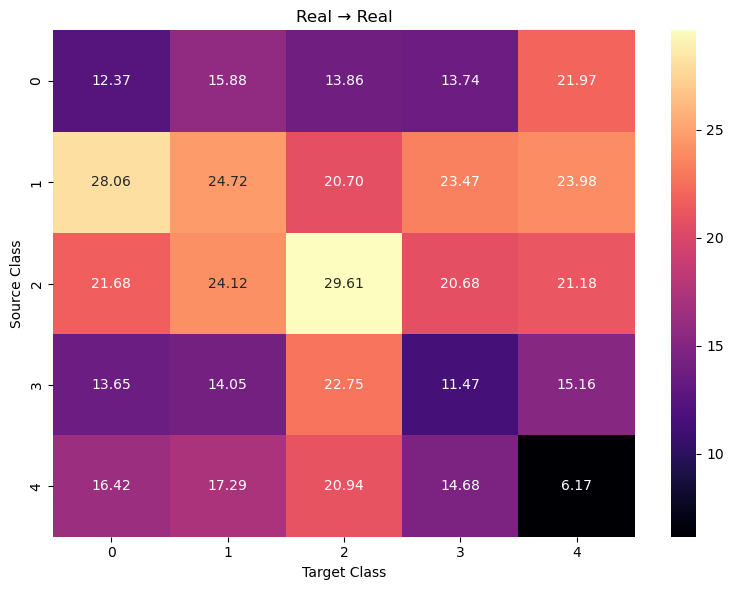

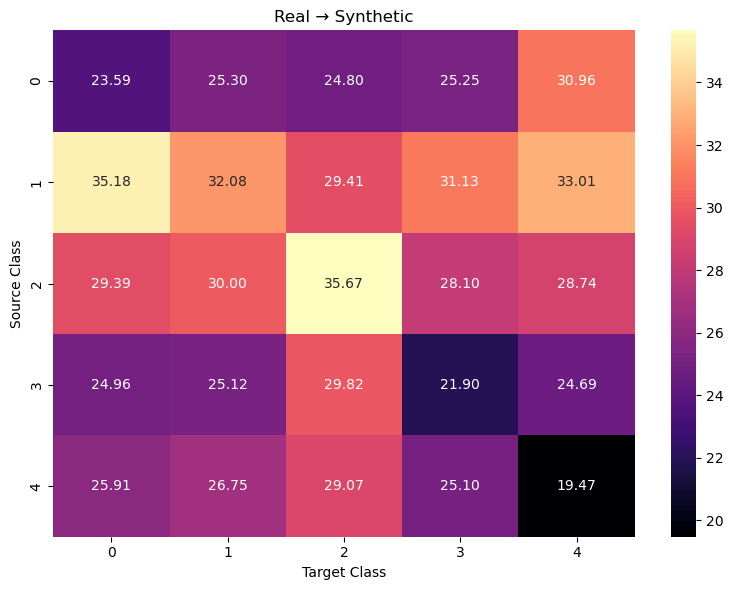

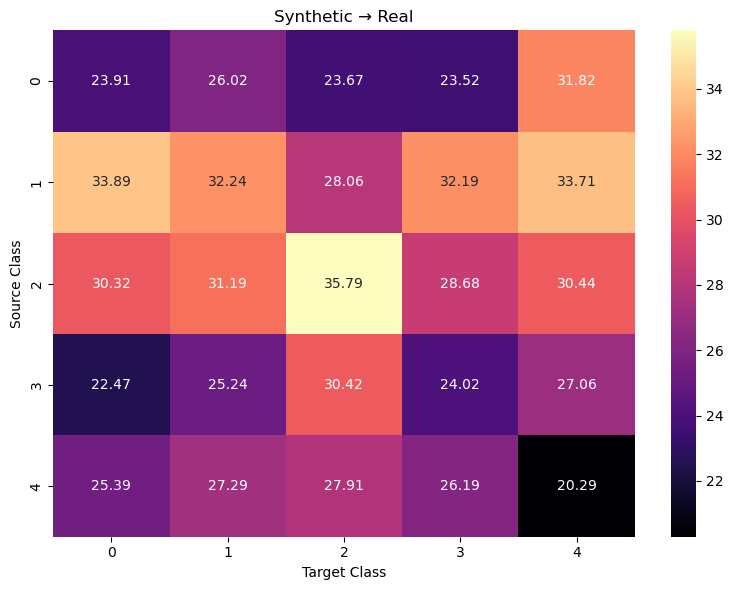

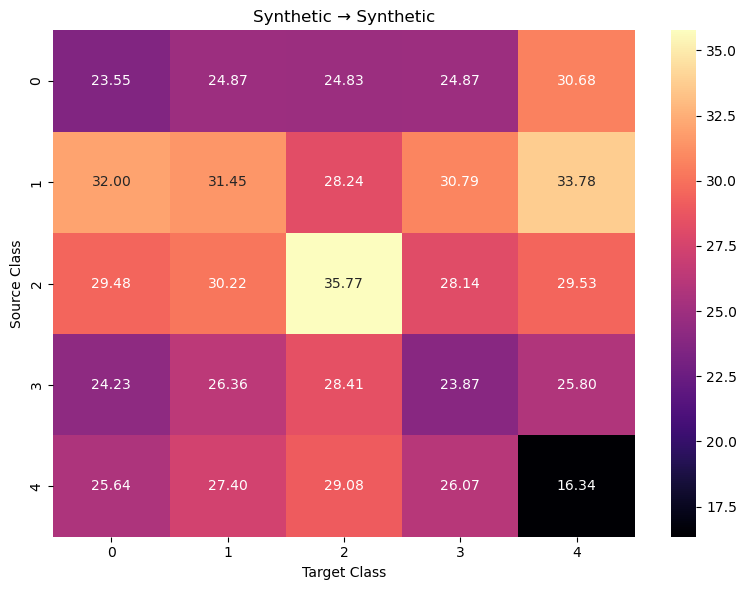

In [98]:
plot_fastdtw_distance_matrix(real_data, real_data, real_labels, real_labels, "Real → Real")
plot_fastdtw_distance_matrix(real_data, synth_data, real_labels, synth_labels, "Real → Synthetic")
plot_fastdtw_distance_matrix(synth_data, real_data, synth_labels, real_labels, "Synthetic → Real")
plot_fastdtw_distance_matrix(synth_data, synth_data, synth_labels, synth_labels, "Synthetic → Synthetic")


## Gaussian Process Classifier (GPC)

In [74]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time


real_data = np.concatenate([
    normalized_samples,
    normalized_samples_secondClass,
    normalized_samples_thirdClass,
    normalized_samples_fourthClass,
    normalized_samples_fifthClass
])
real_labels = np.concatenate([
    np.zeros(len(normalized_samples)),
    np.ones(len(normalized_samples_secondClass)),
    np.full(len(normalized_samples_thirdClass), 2),
    np.full(len(normalized_samples_fourthClass), 3),
    np.full(len(normalized_samples_fifthClass), 4)
])

synth_data = np.concatenate([
    generated_series,
    generated_series_class2,
    generated_series_class3,
    generated_series_class4,
    generated_series_class5
])
synth_labels = np.concatenate([
    np.zeros(len(generated_series)),
    np.ones(len(generated_series_class2)),
    np.full(len(generated_series_class3), 2),
    np.full(len(generated_series_class4), 3),
    np.full(len(generated_series_class5), 4)
])


def evaluate_gpc(train_data, train_labels, test_data, test_labels, description=""):
   
    kernel = ConstantKernel() * RBF(length_scale=10.0) + WhiteKernel(noise_level=1.0)
    
    
    gpc = OneVsRestClassifier(
        GaussianProcessClassifier(
            kernel=kernel,
            optimizer='fmin_l_bfgs_b',  # Optimization method
            n_restarts_optimizer=2,     # Number of restarts to avoid local minima
            max_iter_predict=100,       # Maximum iterations for prediction
            random_state=42             # For reproducibility
        )
    )
    
    print(f"\nTraining Gaussian Process Classifier - {description}...")
    start_time = time.time()
    
    # Fit the model
    gpc.fit(train_data, train_labels)
    
    # Make predictions
    preds = gpc.predict(test_data)
    
    # Calculate training time
    training_time = time.time() - start_time
    
    # Get prediction probabilities (confidence) if available
    if hasattr(gpc, "predict_proba"):
        try:
            probs = gpc.predict_proba(test_data)
            avg_confidence = np.mean([probs[i][pred] for i, pred in enumerate(preds)])
            uncertainty = 1 - avg_confidence
        except:
            uncertainty = "Not Available"
    else:
        uncertainty = "Not Available"
    
    
    print(f"\n=== Gaussian Process Classifier {description} ===")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Model uncertainty: {uncertainty}")
    print(classification_report(test_labels, preds, digits=3))
    print(f"Accuracy: {accuracy_score(test_labels, preds):.3f}")
    print(f"Macro Precision: {precision_score(test_labels, preds, average='macro'):.3f}")
    print(f"Macro Recall:    {recall_score(test_labels, preds, average='macro'):.3f}")
    print(f"Macro F1-Score:  {f1_score(test_labels, preds, average='macro'):.3f}")
    
    return gpc, preds, accuracy_score(test_labels, preds)

# Due to the high computational cost of GPC with large datasets,
# we may need to reduce dimensions or use a subset of data
def reduce_dimensionality(data, n_components=50):
    """Reduce dimensionality of time series data using PCA."""
    from sklearn.decomposition import PCA
    pca = PCA(n_components=n_components)
    return pca.fit_transform(data)


gpc_real_real, preds_real_real, acc_real_real = evaluate_gpc(
    real_data, real_labels, real_data, real_labels, "Real-trained on Real test")

gpc_real_synth, preds_real_synth, acc_real_synth = evaluate_gpc(
    real_data, real_labels, synth_data, synth_labels, "Real-trained on Synth test")

gpc_synth_real, preds_synth_real, acc_synth_real = evaluate_gpc(
    synth_data, synth_labels, real_data, real_labels, "Synth-trained on Real test")

gpc_synth_synth, preds_synth_synth, acc_synth_synth = evaluate_gpc(
    synth_data, synth_labels, synth_data, synth_labels, "Synth-trained on Synth test")

# Generate a summary table of the results
results_df = pd.DataFrame({
    'Training → Testing': ['Real → Real', 'Real → Synthetic', 'Synthetic → Real', 'Synthetic → Synthetic'],
    'Accuracy': [acc_real_real, acc_real_synth, acc_synth_real, acc_synth_synth]
})

print("\n=== Summary of GPC Performance ===")
print(results_df)


def plot_uncertainty_comparison(real_data, synth_data, gpc_real, gpc_synth):
    """Visualize uncertainty patterns in real vs synthetic classifications"""
    try:
        
        n_samples = min(10, len(real_data))
        
        
        real_probs_from_real = gpc_real.predict_proba(real_data[:n_samples])
        real_probs_from_synth = gpc_synth.predict_proba(real_data[:n_samples])
        
        
        real_uncertain_real = 1 - np.max(real_probs_from_real, axis=1)
        real_uncertain_synth = 1 - np.max(real_probs_from_synth, axis=1)
        
        
        plt.figure(figsize=(10, 6))
        plt.bar(np.arange(n_samples) - 0.2, real_uncertain_real, width=0.4, label="Real-trained")
        plt.bar(np.arange(n_samples) + 0.2, real_uncertain_synth, width=0.4, label="Synth-trained")
        plt.xlabel("Sample Index")
        plt.ylabel("Uncertainty (1 - max probability)")
        plt.title("Classification Uncertainty Comparison")
        plt.legend()
        plt.tight_layout()
        plt.savefig("gpc_uncertainty_comparison.png")
        plt.close()
        
        print("Uncertainty visualization created as 'gpc_uncertainty_comparison.png'")
    except Exception as e:
        print(f"Could not create uncertainty visualization: {e}")


try:
    
    if hasattr(gpc_real_real.estimators_[0], "predict_proba"):
        plot_uncertainty_comparison(real_data, synth_data, gpc_real_real, gpc_synth_real)
except:
    print("Could not generate uncertainty visualization.")


Training Gaussian Process Classifier - Real-trained on Real test...


C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: Converg


=== Gaussian Process Classifier Real-trained on Real test ===
Training time: 47.38 seconds
Model uncertainty: Not Available
              precision    recall  f1-score   support

         0.0      0.593     0.905     0.717        95
         1.0      0.852     0.315     0.460        73
         2.0      0.679     0.792     0.731        96
         3.0      0.688     0.719     0.703        89
         4.0      0.000     0.000     0.000        24

    accuracy                          0.660       377
   macro avg      0.562     0.546     0.522       377
weighted avg      0.650     0.660     0.622       377

Accuracy: 0.660
Macro Precision: 0.562
Macro Recall:    0.546
Macro F1-Score:  0.522

Training Gaussian Process Classifier - Real-trained on Synth test...


C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packag


=== Gaussian Process Classifier Real-trained on Synth test ===
Training time: 45.89 seconds
Model uncertainty: Not Available
              precision    recall  f1-score   support

         0.0      0.577     0.863     0.692        95
         1.0      0.778     0.288     0.420        73
         2.0      0.649     0.771     0.705        96
         3.0      0.660     0.697     0.678        89
         4.0      0.000     0.000     0.000        24

    accuracy                          0.634       377
   macro avg      0.533     0.524     0.499       377
weighted avg      0.617     0.634     0.595       377

Accuracy: 0.634
Macro Precision: 0.533
Macro Recall:    0.524
Macro F1-Score:  0.499

Training Gaussian Process Classifier - Synth-trained on Real test...


C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packag


=== Gaussian Process Classifier Synth-trained on Real test ===
Training time: 39.75 seconds
Model uncertainty: Not Available
              precision    recall  f1-score   support

         0.0      0.556     0.842     0.669        95
         1.0      0.808     0.288     0.424        73
         2.0      0.648     0.729     0.686        96
         3.0      0.636     0.708     0.670        89
         4.0      0.000     0.000     0.000        24

    accuracy                          0.621       377
   macro avg      0.530     0.513     0.490       377
weighted avg      0.612     0.621     0.584       377

Accuracy: 0.621
Macro Precision: 0.530
Macro Recall:    0.513
Macro F1-Score:  0.490

Training Gaussian Process Classifier - Synth-trained on Synth test...


C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mrnew\anaconda3\Lib\site-packag


=== Gaussian Process Classifier Synth-trained on Synth test ===
Training time: 40.69 seconds
Model uncertainty: Not Available
              precision    recall  f1-score   support

         0.0      0.613     0.916     0.734        95
         1.0      0.900     0.370     0.524        73
         2.0      0.703     0.812     0.754        96
         3.0      0.720     0.753     0.736        89
         4.0      1.000     0.042     0.080        24

    accuracy                          0.690       377
   macro avg      0.787     0.579     0.566       377
weighted avg      0.741     0.690     0.657       377

Accuracy: 0.690
Macro Precision: 0.787
Macro Recall:    0.579
Macro F1-Score:  0.566

=== Summary of GPC Performance ===
      Training → Testing  Accuracy
0            Real → Real  0.660477
1       Real → Synthetic  0.633952
2       Synthetic → Real  0.620690
3  Synthetic → Synthetic  0.689655
Uncertainty visualization created as 'gpc_uncertainty_comparison.png'


### GPC - Uncertainty analysis

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from scipy.stats import entropy
import pandas as pd
from IPython.display import display

def perform_uncertainty_analysis(real_data, real_labels, synth_data, synth_labels, 
                               gpc_real_real, gpc_real_synth, gpc_synth_real, gpc_synth_synth):
    """
    Comprehensive uncertainty analysis for GPC models comparing real and synthetic data
    """
    
    try:
        # Real→Real probabilities
        real_real_probs = gpc_real_real.predict_proba(real_data)
        # Real→Synth probabilities
        real_synth_probs = gpc_real_synth.predict_proba(synth_data)
        # Synth→Real probabilities
        synth_real_probs = gpc_synth_real.predict_proba(real_data)
        # Synth→Synth probabilities
        synth_synth_probs = gpc_synth_synth.predict_proba(synth_data)
        
        # 2. Plot reliability diagrams (calibration curves)
        plt.figure(figsize=(16, 12))
        
        # Create 2x2 grid for our four scenarios
        plt.subplot(2, 2, 1)
        plot_calibration_curve(real_real_probs, real_labels, "Real→Real")
        
        plt.subplot(2, 2, 2)
        plot_calibration_curve(real_synth_probs, synth_labels, "Real→Synthetic")
        
        plt.subplot(2, 2, 3)
        plot_calibration_curve(synth_real_probs, real_labels, "Synthetic→Real")
        
        plt.subplot(2, 2, 4)
        plot_calibration_curve(synth_synth_probs, synth_labels, "Synthetic→Synthetic")
        
        plt.tight_layout()
        plt.savefig("calibration_curves_comparison.png")
        # Display the figure in notebook
        plt.show()
        
        # 3. Calculate uncertainty metrics
        results = calculate_uncertainty_metrics(
            real_real_probs, real_labels,
            real_synth_probs, synth_labels,
            synth_real_probs, real_labels,
            synth_synth_probs, synth_labels
        )
        
        # 4. Create uncertainty distribution histograms
        plot_uncertainty_distributions(
            real_real_probs, real_synth_probs, 
            synth_real_probs, synth_synth_probs
        )
        
        # 5. Analyze class-specific uncertainty
        plot_class_specific_uncertainty(
            real_real_probs, real_labels,
            real_synth_probs, synth_labels,
            synth_real_probs, real_labels,
            synth_synth_probs, synth_labels
        )
        
        return results
        
    except Exception as e:
        print(f"Error in uncertainty analysis: {e}")
        import traceback
        traceback.print_exc()
        return None

def plot_calibration_curve(y_probs, y_true, title):
    """
    Plot calibration curve for a single scenario
    """
    # Get max probability for each sample as confidence
    y_conf = np.max(y_probs, axis=1)
    y_pred = np.argmax(y_probs, axis=1)
    
    # Convert to binary problem for each class
    n_classes = y_probs.shape[1]
    
    
    for i in range(n_classes):
        
        if sum(y_true == i) < 10:
            continue
            
        
        binary_true = (y_true == i).astype(int)
        binary_conf = y_probs[:, i]
        
        
        prob_true, prob_pred = calibration_curve(binary_true, binary_conf, n_bins=10)
        
        plt.plot(prob_pred, prob_true, marker='o', linewidth=1, 
                 label=f'Class {i}')
    
   
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
    
    plt.title(f'Calibration Curve - {title}')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.legend(loc='best')
    plt.grid(True)

def calculate_uncertainty_metrics(real_real_probs, real_labels,
                               real_synth_probs, synth_labels,
                               synth_real_probs, real_labels_again,
                               synth_synth_probs, synth_labels_again):
    """
    Calculate various uncertainty metrics for all scenarios
    """
    
    results = {
        'scenario': ['Real→Real', 'Real→Synthetic', 'Synthetic→Real', 'Synthetic→Synthetic'],
        'mean_confidence': [],
        'mean_uncertainty': [],
        'entropy': [],
        'ece': []  # Expected Calibration Error
    }
    
    
    for name, probs, true_labels in [
        ('Real→Real', real_real_probs, real_labels),
        ('Real→Synthetic', real_synth_probs, synth_labels),
        ('Synthetic→Real', synth_real_probs, real_labels_again),
        ('Synthetic→Synthetic', synth_synth_probs, synth_labels_again)
    ]:
        # Mean confidence (max probability)
        mean_conf = np.mean(np.max(probs, axis=1))
        results['mean_confidence'].append(round(mean_conf, 3))
        
        # Mean uncertainty (1 - max probability)
        mean_uncert = 1 - mean_conf
        results['mean_uncertainty'].append(round(mean_uncert, 3))
        
        # Mean entropy of probability distributions
        mean_entropy = np.mean([entropy(p) for p in probs])
        results['entropy'].append(round(mean_entropy, 3))
        
        
        ece = calculate_ece(probs, true_labels)
        results['ece'].append(round(ece, 3))
    
    
    results_df = pd.DataFrame(results)
    print("\n=== Uncertainty Metrics Comparison ===")
    display(results_df) 
    
    
    results_df.to_csv("uncertainty_metrics.csv", index=False)
    
    return results_df

def calculate_ece(probs, true_labels, n_bins=10):
    """
    Calculate Expected Calibration Error
    """
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)
    accuracies = (predictions == true_labels).astype(float)
    
    
    bin_indices = np.digitize(confidences, np.linspace(0, 1, n_bins+1)[:-1])
    
    # Calculate ECE
    ece = 0
    for bin_idx in range(1, n_bins+1):
        bin_mask = bin_indices == bin_idx
        if np.any(bin_mask):
            bin_conf = np.mean(confidences[bin_mask])
            bin_acc = np.mean(accuracies[bin_mask])
            bin_size = np.sum(bin_mask)
            ece += (bin_size / len(confidences)) * abs(bin_acc - bin_conf)
    
    return ece

def plot_uncertainty_distributions(real_real_probs, real_synth_probs, 
                                synth_real_probs, synth_synth_probs):
    """
    Plot histograms of uncertainty distributions
    """
    plt.figure(figsize=(16, 10))
    
    
    real_real_uncert = 1 - np.max(real_real_probs, axis=1)
    real_synth_uncert = 1 - np.max(real_synth_probs, axis=1)
    synth_real_uncert = 1 - np.max(synth_real_probs, axis=1)
    synth_synth_uncert = 1 - np.max(synth_synth_probs, axis=1)
    
    
    plt.subplot(2, 2, 1)
    plt.hist(real_real_uncert, bins=20, alpha=0.7)
    plt.title('Uncertainty Distribution: Real→Real')
    plt.xlabel('Uncertainty (1 - max probability)')
    plt.ylabel('Count')
    
    plt.subplot(2, 2, 2)
    plt.hist(real_synth_uncert, bins=20, alpha=0.7)
    plt.title('Uncertainty Distribution: Real→Synthetic')
    plt.xlabel('Uncertainty (1 - max probability)')
    plt.ylabel('Count')
    
    plt.subplot(2, 2, 3)
    plt.hist(synth_real_uncert, bins=20, alpha=0.7)
    plt.title('Uncertainty Distribution: Synthetic→Real')
    plt.xlabel('Uncertainty (1 - max probability)')
    plt.ylabel('Count')
    
    plt.subplot(2, 2, 4)
    plt.hist(synth_synth_uncert, bins=20, alpha=0.7)
    plt.title('Uncertainty Distribution: Synthetic→Synthetic')
    plt.xlabel('Uncertainty (1 - max probability)')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.savefig("uncertainty_distributions.png")
    
    plt.show()

def plot_class_specific_uncertainty(real_real_probs, real_labels,
                                  real_synth_probs, synth_labels,
                                  synth_real_probs, real_labels_again,
                                  synth_synth_probs, synth_labels_again):
    """
    Analyze and plot class-specific uncertainty
    """
    n_classes = real_real_probs.shape[1]
    
    
    class_uncertainties = {
        'Real→Real': [],
        'Real→Synthetic': [],
        'Synthetic→Real': [],
        'Synthetic→Synthetic': []
    }
    
    for c in range(n_classes):
        # Real→Real uncertainty for this class
        mask = real_labels == c
        if np.sum(mask) > 0:
            class_uncertainties['Real→Real'].append(
                np.mean(1 - real_real_probs[mask, c]))
        else:
            class_uncertainties['Real→Real'].append(np.nan)
        
        # Real→Synthetic uncertainty for this class
        mask = synth_labels == c
        if np.sum(mask) > 0:
            class_uncertainties['Real→Synthetic'].append(
                np.mean(1 - real_synth_probs[mask, c]))
        else:
            class_uncertainties['Real→Synthetic'].append(np.nan)
        
        # Synthetic→Real uncertainty for this class
        mask = real_labels_again == c
        if np.sum(mask) > 0:
            class_uncertainties['Synthetic→Real'].append(
                np.mean(1 - synth_real_probs[mask, c]))
        else:
            class_uncertainties['Synthetic→Real'].append(np.nan)
        
        # Synthetic→Synthetic uncertainty for this class
        mask = synth_labels_again == c
        if np.sum(mask) > 0:
            class_uncertainties['Synthetic→Synthetic'].append(
                np.mean(1 - synth_synth_probs[mask, c]))
        else:
            class_uncertainties['Synthetic→Synthetic'].append(np.nan)
    
    
    plt.figure(figsize=(14, 8))
    bar_width = 0.2
    x = np.arange(n_classes)
    
    plt.bar(x - 1.5*bar_width, class_uncertainties['Real→Real'], 
            width=bar_width, label='Real→Real')
    plt.bar(x - 0.5*bar_width, class_uncertainties['Real→Synthetic'], 
            width=bar_width, label='Real→Synthetic')
    plt.bar(x + 0.5*bar_width, class_uncertainties['Synthetic→Real'], 
            width=bar_width, label='Synthetic→Real')
    plt.bar(x + 1.5*bar_width, class_uncertainties['Synthetic→Synthetic'], 
            width=bar_width, label='Synthetic→Synthetic')
    
    plt.xlabel('Class')
    plt.ylabel('Mean Uncertainty')
    plt.title('Class-Specific Uncertainty Comparison')
    plt.xticks(x, [f'Class {i}' for i in range(n_classes)])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("class_specific_uncertainty.png")
    
    plt.show()

Running uncertainty analysis...


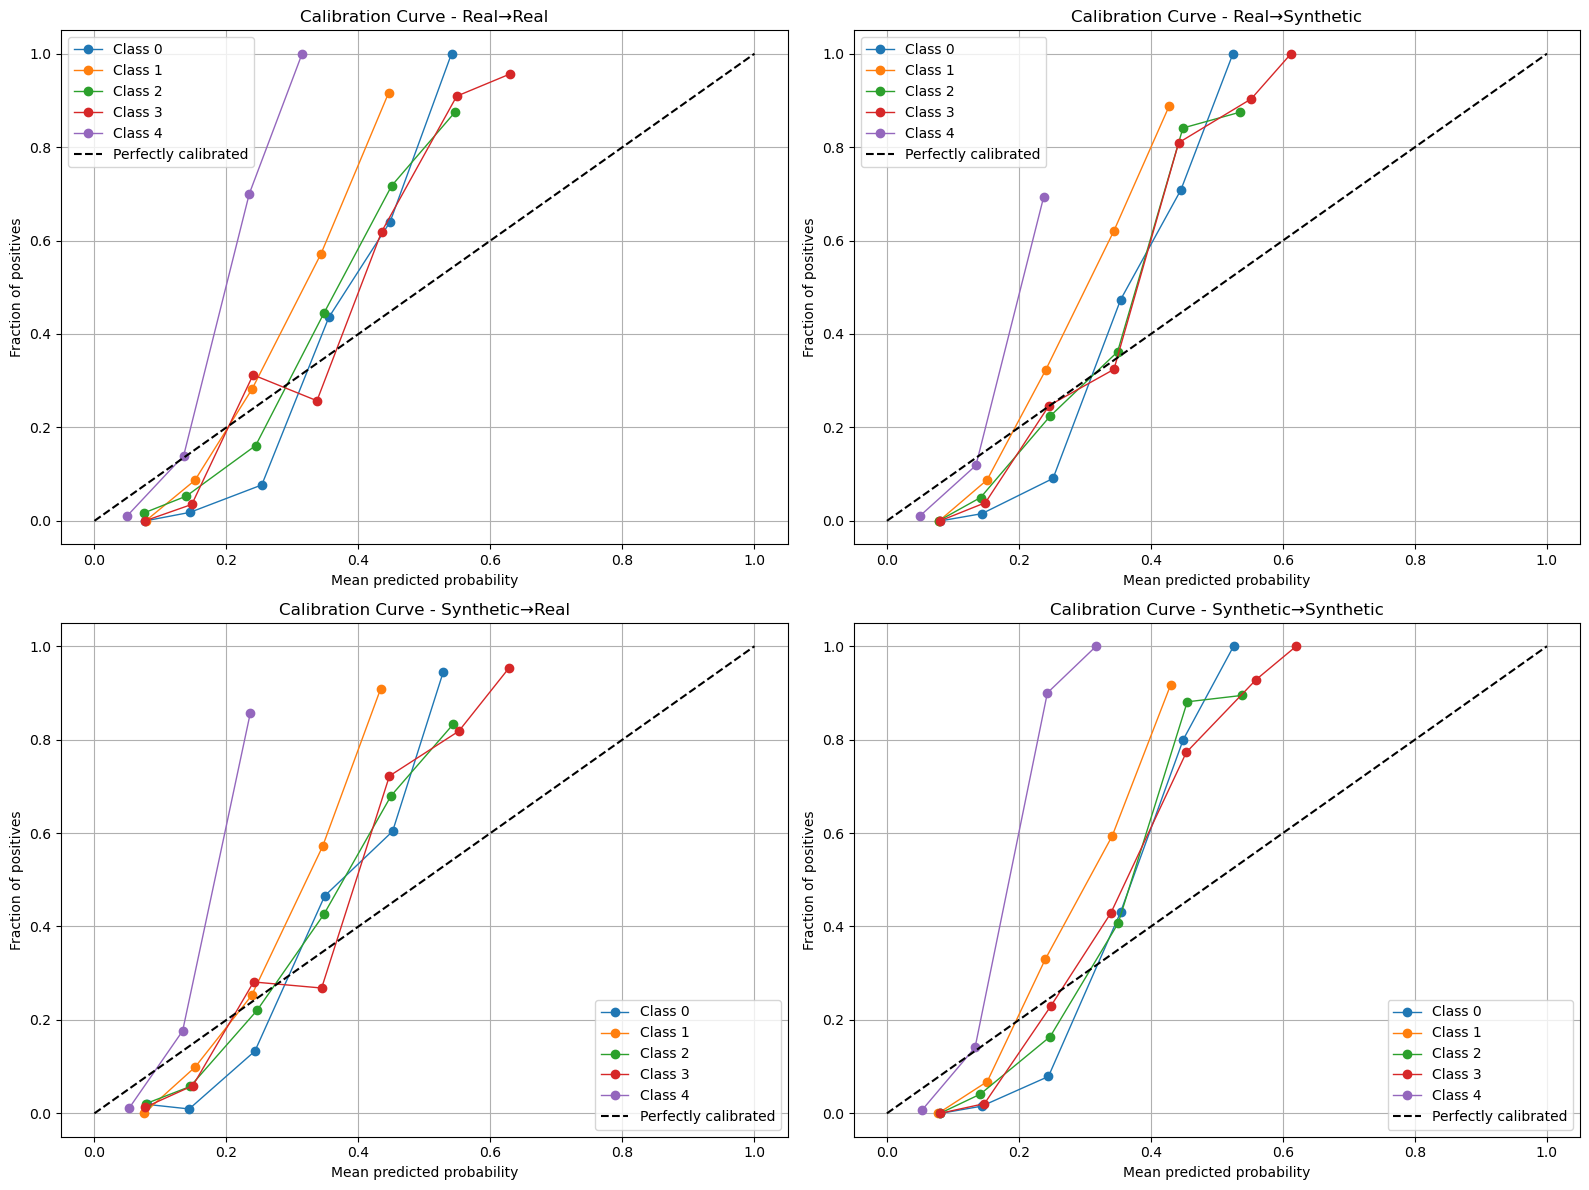


=== Uncertainty Metrics Comparison ===


scenario  mean_confidence  mean_uncertainty  entropy    ece
0            Real→Real            0.437             0.563    1.368  0.229
1       Real→Synthetic            0.414             0.586    1.403  0.232
2       Synthetic→Real            0.427             0.573    1.382  0.193
3  Synthetic→Synthetic            0.421             0.579    1.394  0.273

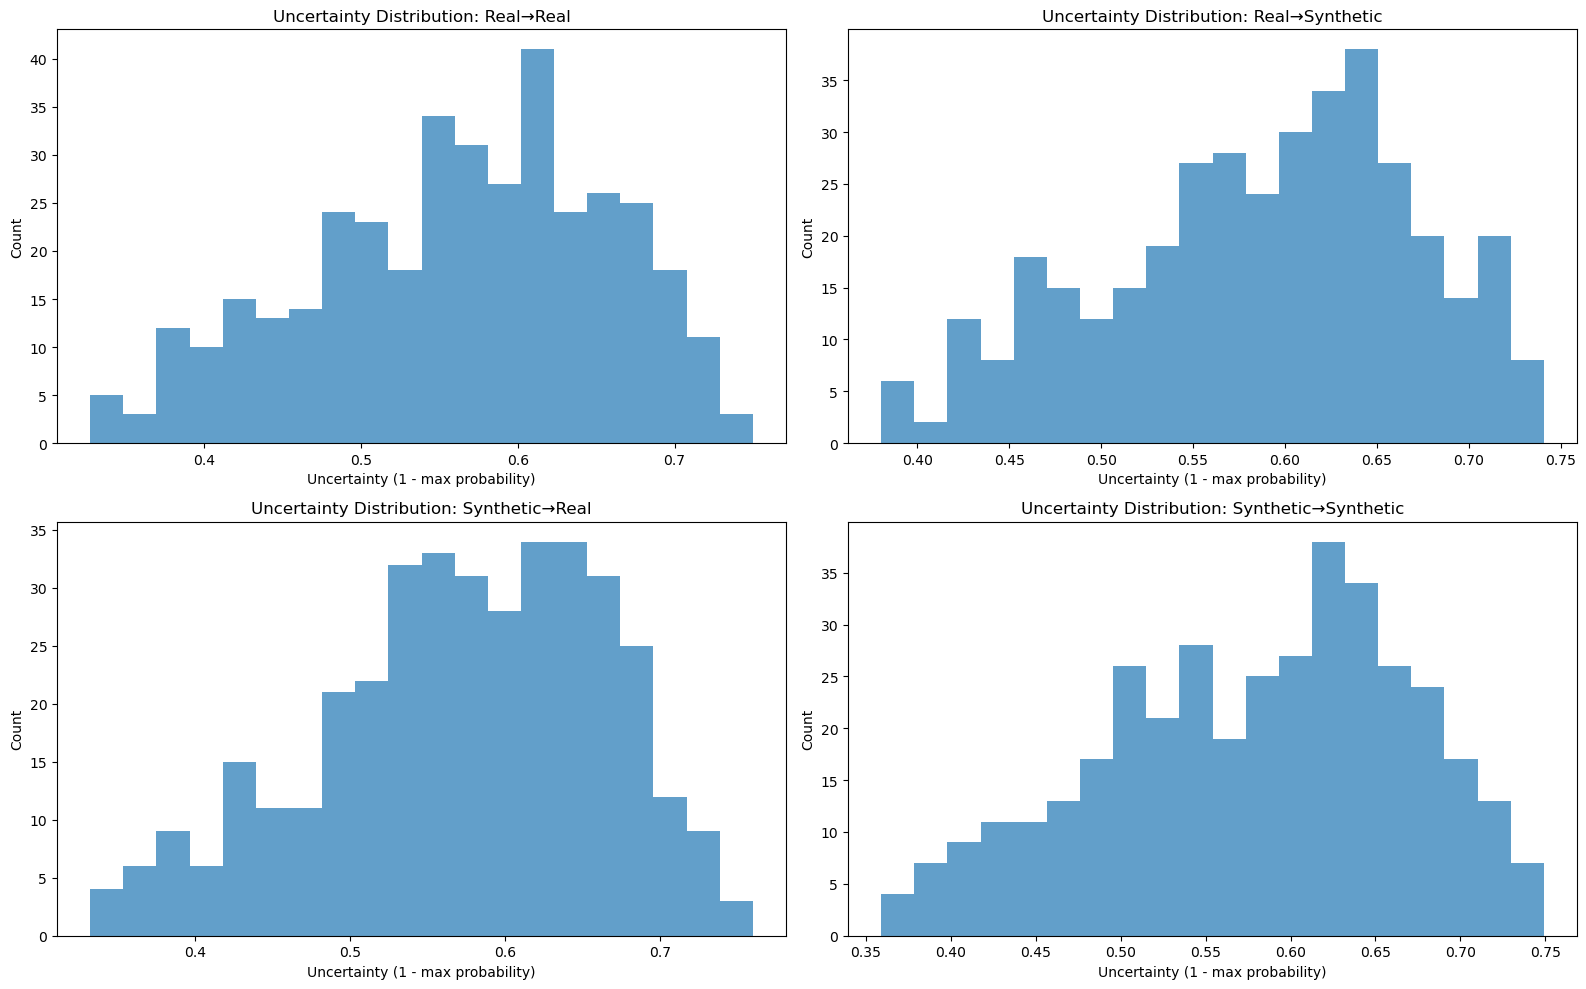


Uncertainty analysis completed.


In [76]:


print("Running uncertainty analysis...")
uncertainty_results = perform_uncertainty_analysis(
    real_data, real_labels, synth_data, synth_labels,
    gpc_real_real, gpc_real_synth, gpc_synth_real, gpc_synth_synth
)

print("\nUncertainty analysis completed.")

### GPC - Latent space

In [77]:
from sklearn.manifold import TSNE
import seaborn as sns

def plot_all_latent_spaces_bundled(data_label_model_pairs, layout=(2, 2), figsize=(16, 12), save_name="gpc_latent_bundled.png"):
    try:
        fig, axes = plt.subplots(layout[0], layout[1], figsize=figsize)
        axes = axes.flatten()

        for i, (data, labels, model, title) in enumerate(data_label_model_pairs):
            if i >= len(axes): break
            
           
            probs = model.predict_proba(data)
            uncertainty = 1 - np.max(probs, axis=1)

            
            reducer = TSNE(n_components=2, random_state=42, perplexity=30)
            embedding = reducer.fit_transform(data)

            
            df = pd.DataFrame({
                'x': embedding[:, 0],
                'y': embedding[:, 1],
                'Uncertainty': uncertainty
            })

            
            sc = axes[i].scatter(df['x'], df['y'], c=df['Uncertainty'], cmap='viridis', s=35)
            axes[i].set_title(title)
            axes[i].set_xticks([])
            axes[i].set_yticks([])

        
        cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.015, pad=0.04)
        cbar.set_label("Predictive Uncertainty")

        plt.suptitle("Latent Space Visualization of GPC Uncertainty", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(save_name)
        plt.show()

    except Exception as e:
        print(f"Error during bundled latent plot generation: {e}")


In [78]:

plot_inputs = [
    (real_data, real_labels, gpc_real_real, "Real-trained GPC on Real Data"),
    (synth_data, synth_labels, gpc_real_synth, "Real-trained GPC on Synthetic Data"),
    (real_data, real_labels, gpc_synth_real, "Synth-trained GPC on Real Data"),
    (synth_data, synth_labels, gpc_synth_synth, "Synth-trained GPC on Synthetic Data"),
]


plot_all_latent_spaces_bundled(plot_inputs)


C:\Users\mrnew\AppData\Local\Temp\ipykernel_13880\132364953.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
